# Inlezen en Berekenen van RSSI-ruis
Deze notebook leest RSSI-metingen in van drie verschillende Raspberry Pi’s, berekent de parameters voor het logaritmisch padverliesmodel en bepaalt de ruis (sigma van de residuen). Daarnaast worden de calibratiepunten visueel weergegeven.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import glob
import os  
import json


## 1. Inlezen van data
We laden zowel de *calibration points* als de *session* bestanden in. De calibration points zijn gemiddelden per afstand (minder nauwkeurig), terwijl de session-bestanden meerdere metingen per afstand bevatten (meer nauwkeurig).

In [2]:
# Pad naar jouw mappen
BASE_FOLDER = r"C:\Users\noort\OneDrive - UGent (1)\Master sem1\Smart instrumentation\calibratie"

pi_folders = {
    "Pi4": os.path.join(BASE_FOLDER, "pi4"),
    "Pi5 rood": os.path.join(BASE_FOLDER, "pi5rood"),
    "Pi5 zwart": os.path.join(BASE_FOLDER, "pi5zwart"),
}

data = {}

# ---------- ALLE CSV’S AUTOMATISCH INLEZEN ----------
for naam, folder in pi_folders.items():

    all_files = glob.glob(os.path.join(folder, "*.csv"))
    df_list = []

    for file in all_files:
        df = pd.read_csv(file)
        df.columns = df.columns.str.strip().str.lower()

        # numeriek maken
        df["rssi_dbm"] = pd.to_numeric(df["rssi_dbm"], errors="coerce")
        df["dist_m"]   = pd.to_numeric(df["dist_m"],   errors="coerce")

        # ❗ filter slechte rijen eruit (belangrijk)
        df = df.dropna(subset=["dist_m", "rssi_dbm"])
        df = df[df["dist_m"] >= 0]    #  geen negatieve waarden

        df_list.append(df)

    data[naam] = pd.concat(df_list, ignore_index=True)

print("KLAAR — alle data is ingelezen!")


KLAAR — alle data is ingelezen!


Controle welke afstanden zitten er in 

In [3]:
for naam, df in data.items():
    print(naam, sorted(df["dist_m"].unique()))


Pi4 [np.float64(0.0), np.float64(0.25), np.float64(0.5), np.float64(0.75), np.float64(1.0), np.float64(1.5), np.float64(2.0), np.float64(2.5), np.float64(3.0), np.float64(3.5), np.float64(4.0), np.float64(4.5), np.float64(5.0), np.float64(6.0), np.float64(7.0), np.float64(8.0), np.float64(9.0), np.float64(10.0)]
Pi5 rood [np.float64(0.0), np.float64(0.25), np.float64(0.5), np.float64(0.75), np.float64(1.0), np.float64(1.5), np.float64(2.0), np.float64(2.5), np.float64(3.0), np.float64(3.5), np.float64(4.0), np.float64(4.5), np.float64(5.0), np.float64(6.0), np.float64(7.0), np.float64(8.0), np.float64(9.0), np.float64(10.0)]
Pi5 zwart [np.float64(0.0), np.float64(0.25), np.float64(0.5), np.float64(0.75), np.float64(1.0), np.float64(1.5), np.float64(2.0), np.float64(2.5), np.float64(3.0), np.float64(3.5), np.float64(4.0), np.float64(4.5), np.float64(5.0), np.float64(6.0), np.float64(7.0), np.float64(8.0), np.float64(9.0), np.float64(10.0)]


## 2. Functie om parameters te berekenen
We gebruiken een logaritmische regressie van de vorm:
$$ RSSI = C - n \log_{10}(d) $$
waarbij:
- *n* het padverliesexponent is,
- *C* de intercept (RSSI bij 1 meter),
- *sigma_residual_db* de standaardafwijking van de residuen (ruis) is.

In [4]:
from scipy.stats import linregress

def bereken_parameters(df):
    # Zorg dat afstanden > 0 zijn (log10 vereist dat)
    df = df[df['dist_m'] > 0].copy()

    x = np.log10(df['dist_m'].to_numpy())
    y = df['rssi_dbm'].to_numpy()

    slope, intercept, r_value, p_value, std_err = linregress(x, y)

    # Residuen en ruis (sample std, ddof=1)
    residuals = y - (slope * x + intercept)
    sigma_residual_db = residuals.std(ddof=1)
# ---------------------------------------------------------
# GLOBALE SIGMA (één waarde)
# ---------------------------------------------------------
# We berekenen de standaardafwijking van de residuen
# rond de regressielijn. Dit geeft één sigma-waarde
# voor de totale variabiliteit van RSSI rond het model.
#
# Dit is NIET sigma per afstand.
# Het is één algemene shadowing-ruisparameter.
# ---------------------------------------------------------

    # Belangrijk: slope = -10 * n  ->  n = -slope / 10
    n = -slope / 10.0

    return {
        'path_loss_n': float(n),          # correcte n
        'C_intercept': float(intercept),  # C (RSSI bij 1 m)
        'slope_c1': float(slope),         # = -10 * n
        'sigma_residual_db': float(sigma_residual_db),
        'R2': float(r_value ** 2)
    }


## 3. Parameters berekenen per Raspberry Pi
We groeperen de data per afstand en berekenen de gemiddelde RSSI, vervolgens voeren we de regressie uit en slaan we de resultaten op.

In [5]:
results = {}

from scipy.stats import linregress

for naam, df in data.items():

    # Kolommen proper maken
    df.columns = [c.strip().lower() for c in df.columns]

    # Groeperen per afstand — rssi middelen
    grouped = df.groupby("dist_m").mean(numeric_only=True).reset_index()

    results[naam] = bereken_parameters(grouped)

results


{'Pi4': {'path_loss_n': 1.792384804317399,
  'C_intercept': -56.10961411634146,
  'slope_c1': -17.92384804317399,
  'sigma_residual_db': 4.518895251689665,
  'R2': 0.7727676094716859},
 'Pi5 rood': {'path_loss_n': 2.216342145288338,
  'C_intercept': -51.77897198540094,
  'slope_c1': -22.16342145288338,
  'sigma_residual_db': 1.7902245835650132,
  'R2': 0.9707014330379007},
 'Pi5 zwart': {'path_loss_n': 1.8124223913343713,
  'C_intercept': -57.32078976647304,
  'slope_c1': -18.124223913343712,
  'sigma_residual_db': 2.3381292947522567,
  'R2': 0.9285132430141259}}

## 4. Gecombineerde parameters
We nemen het gemiddelde van alle individuele resultaten om een gecombineerd model te bekomen.

In [6]:
params = {'combined': {}}
all_vals = np.array([r['path_loss_n'] for r in results.values()])
params['combined']['path_loss_n'] = float(np.mean(all_vals))
params['combined']['C_intercept'] = float(np.mean([r['C_intercept'] for r in results.values()]))
params['combined']['slope_c1'] = float(np.mean([r['slope_c1'] for r in results.values()]))
params['combined']['sigma_residual_db'] = float(np.mean([r['sigma_residual_db'] for r in results.values()]))
params['combined']['R2'] = float(np.mean([r['R2'] for r in results.values()]))
params

{'combined': {'path_loss_n': 1.9403831136467027,
  'C_intercept': -55.06979195607181,
  'slope_c1': -19.40383113646703,
  'sigma_residual_db': 2.8824163766689783,
  'R2': 0.8906607618412375}}

## 5. Exporteren naar JSON
We slaan zowel de individuele als gecombineerde parameters op in een JSON-bestand.

In [7]:

with open("rssi_parameters_AndereMeetwaarden.json", "w") as f:
    json.dump({'individual': results, **params}, f, indent=4)

print("Parameters opgeslagen in rssi_parameters.json")


Parameters opgeslagen in rssi_parameters.json


## 6. Visualisatie van calibratiepunten
We tonen voor elke Raspberry Pi een plot van RSSI versus afstand, zodat het verschil in signaalsterkte duidelijk zichtbaar is.

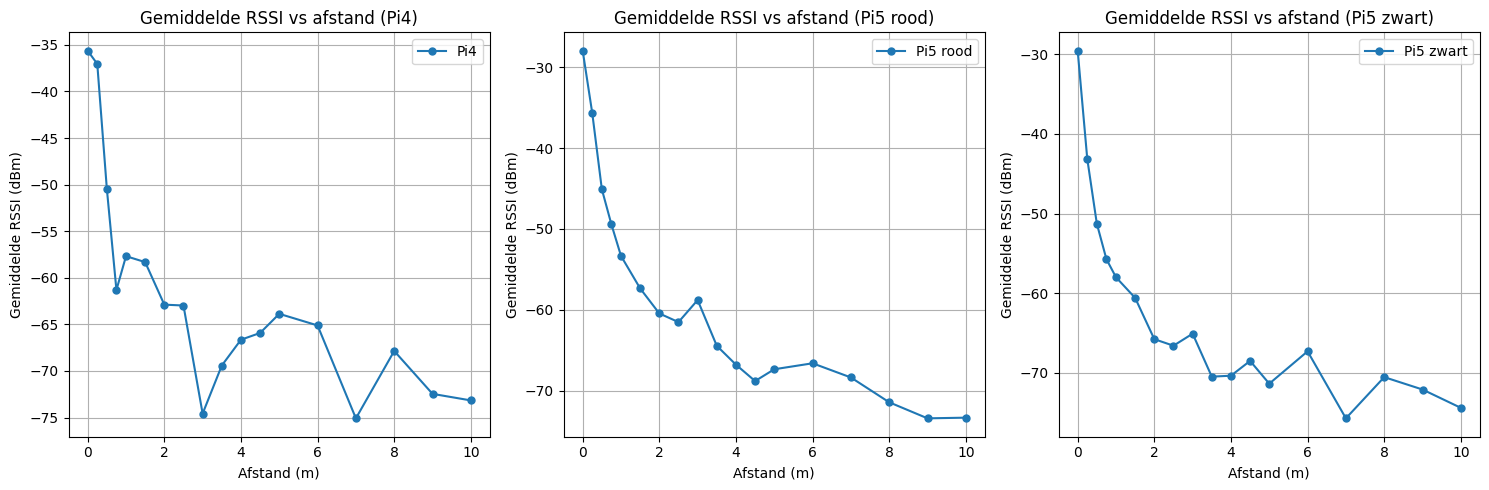

In [8]:
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

for ax, (naam, df) in zip(axes, data.items()):

    # Gemiddelde RSSI per afstand
    grouped = df.groupby("dist_m")["rssi_dbm"].mean().reset_index()

    # plot
    ax.plot(grouped['dist_m'], grouped['rssi_dbm'], 'o-', label=f'{naam}', markersize=5)

    ax.set_title(f'Gemiddelde RSSI vs afstand ({naam})')
    ax.set_xlabel('Afstand (m)')
    ax.set_ylabel('Gemiddelde RSSI (dBm)')
    ax.grid(True)
    ax.legend()

plt.tight_layout()
plt.show()


Met de ideale curve erbij 

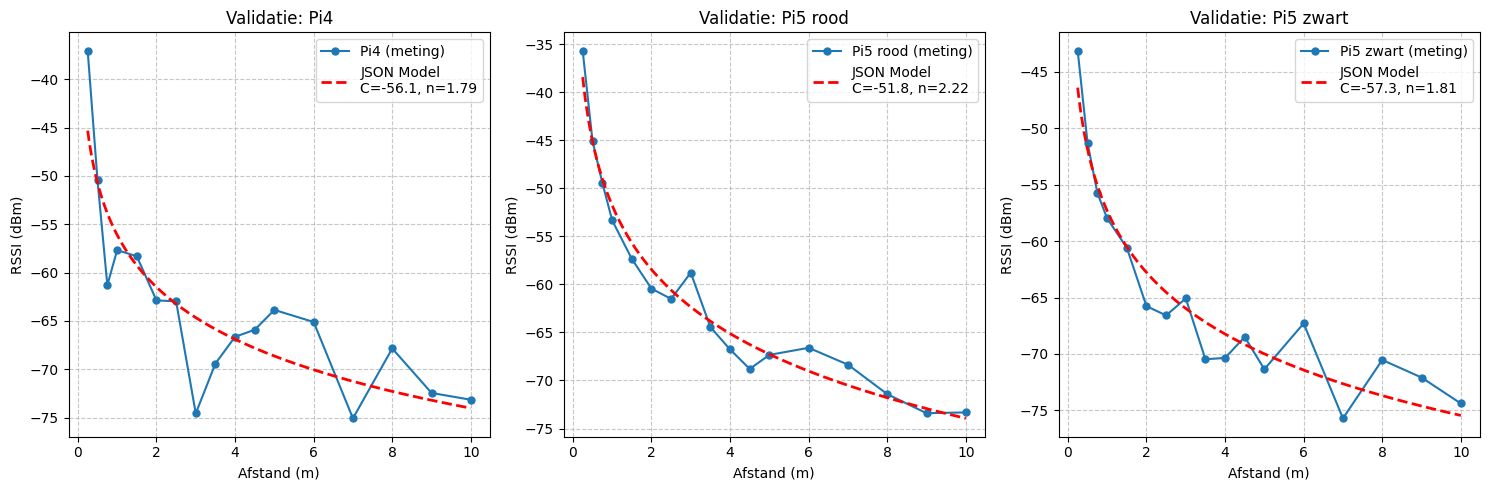

In [9]:
import json
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# --- 1) Parameters inladen uit JSON ---
with open("rssi_parameters_AndereMeetwaarden.json", "r") as f:
    params = json.load(f)

per_pi = params["individual"]   # hier zitten Pi4, Pi5 rood, Pi5 zwart

# --- 2) Path-loss model ---
def log_pathloss_model(d, C, n):
    return C - 10 * n * np.log10(d)

# --- 3) Plot gemeten RSSI + ideale curve ---
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

# Zorg dat 'data' hierboven al gedefinieerd is!
for ax, (naam, df) in zip(axes, data.items()):

    # Gemiddelde RSSI per afstand
    grouped = df.groupby("dist_m")["rssi_dbm"].mean().reset_index()

    # d = 0 weglaten (log en model)
    mask = grouped["dist_m"] > 0
    d = grouped.loc[mask, "dist_m"].values
    rssi = grouped.loc[mask, "rssi_dbm"].values

    # 1) Gemeten data (Blauw)
    ax.plot(d, rssi, 'o-', label=f"{naam} (meting)", markersize=5)

    # 2) Ideale curve ophalen uit JSON
    if naam in per_pi:
        C = per_pi[naam]["C_intercept"]
        n = per_pi[naam]["path_loss_n"]

        # Curve berekenen
        d_fit = np.linspace(min(d), max(d), 300)
        rssi_fit = log_pathloss_model(d_fit, C, n)

        ax.plot(d_fit, rssi_fit, 'r--', linewidth=2,
                label=f"JSON Model\nC={C:.1f}, n={n:.2f}")
    else:
        print(f"Let op: Geen parameters gevonden voor '{naam}' in de JSON file.")

    ax.set_title(f"Validatie: {naam}")
    ax.set_xlabel("Afstand (m)")
    ax.set_ylabel("RSSI (dBm)")
    ax.grid(True, linestyle="--", alpha=0.7)
    ax.legend()

plt.tight_layout()
plt.show()

De onderstaande code is niet gebasseerd op de Json berekende parameters per PI maar opnieuw een gevisualiserde controle met de C en n 

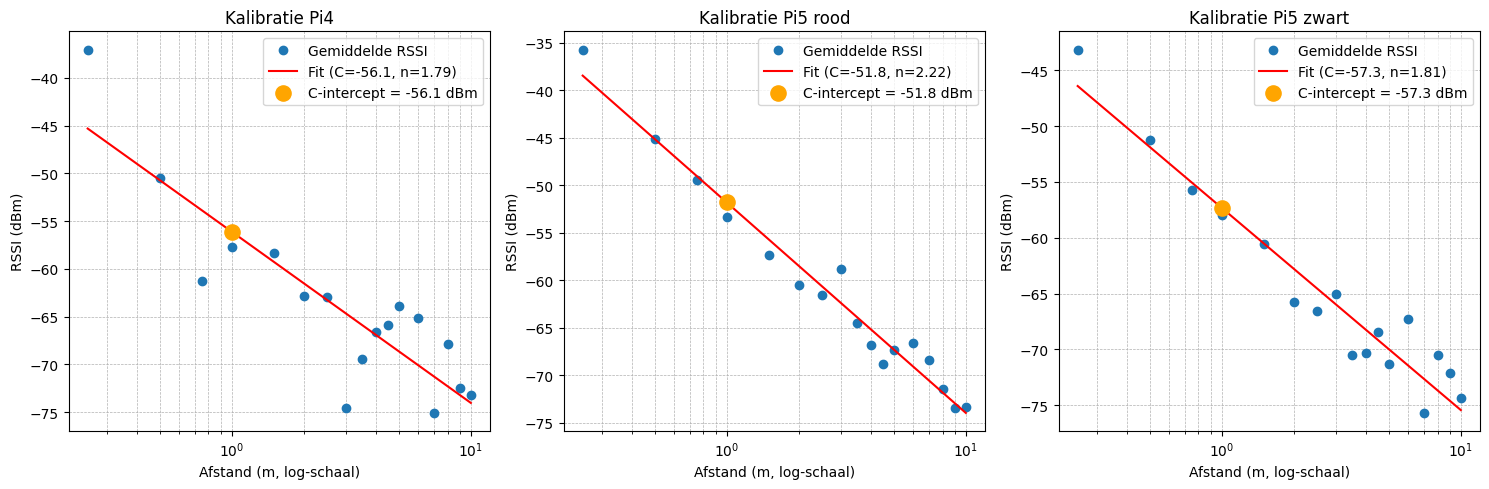

In [10]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit

def log_pathloss_model(d, C, n):
    return C - 10 * n * np.log10(d)

fig, axes = plt.subplots(1, 3, figsize=(15, 5))

for ax, (naam, df) in zip(axes, data.items()):

    grouped = df.groupby("dist_m")["rssi_dbm"].mean().reset_index()

    # ❗❗ VERWIJDER d = 0 VOOR FITTEN / LOG
    mask = grouped["dist_m"] > 0
    d = grouped.loc[mask, "dist_m"].values
    rssi = grouped.loc[mask, "rssi_dbm"].values

    # Curve fitting
    popt, pcov = curve_fit(log_pathloss_model, d, rssi, p0=[-40, 2])
    C_fit, n_fit = popt

    # Glad model
    d_fit = np.logspace(np.log10(min(d)), np.log10(max(d)), 200)
    rssi_fit = log_pathloss_model(d_fit, C_fit, n_fit)

    # Plot punten
    ax.plot(d, rssi, "o", label="Gemiddelde RSSI")

    # Fit curve
    ax.plot(d_fit, rssi_fit, "-", color="red", label=f"Fit (C={C_fit:.1f}, n={n_fit:.2f})")

    # C-intercept
    ax.scatter(1, C_fit, color="orange", s=120, zorder=5,
               label=f"C-intercept = {C_fit:.1f} dBm")

    ax.set_xscale("log")
    ax.set_title(f"Kalibratie {naam}")
    ax.set_xlabel("Afstand (m, log-schaal)")
    ax.set_ylabel("RSSI (dBm)")
    ax.grid(True, which="both", ls="--", lw=0.5)
    ax.legend()

plt.tight_layout()
plt.show()


Grafieken samengevoegd

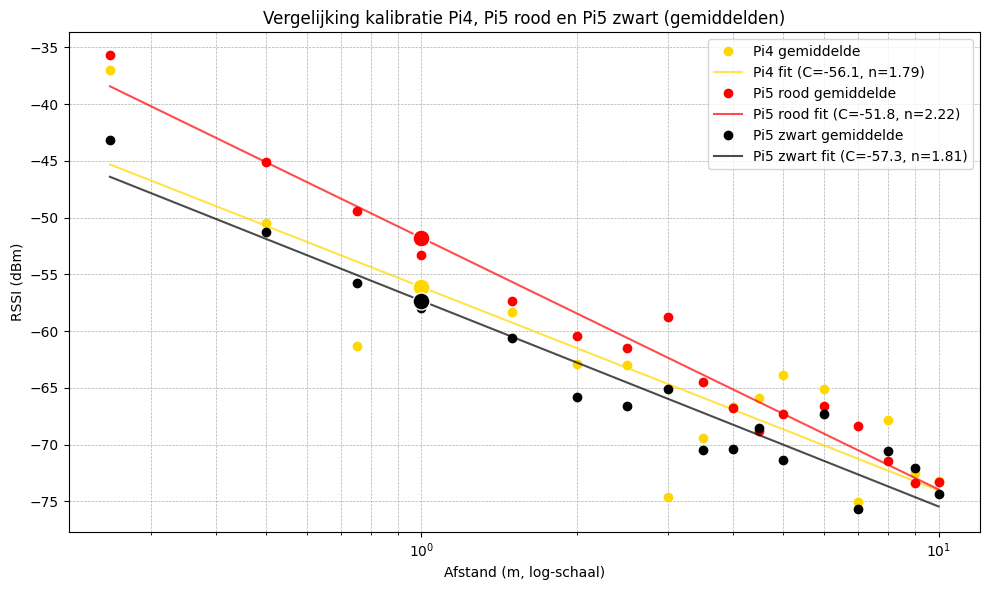

In [11]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit

def log_pathloss_model(d, C, n):
    return C - 10 * n * np.log10(d)

colors = {
    "Pi4": "gold",
    "Pi5 rood": "red",
    "Pi5 zwart": "black"
}

plt.figure(figsize=(10, 6))

for naam, df in data.items():

    grouped = df.groupby("dist_m")["rssi_dbm"].mean().reset_index()

    # ❗❗ FILTER DIST = 0 WEG — anders crasht log10()
    mask = grouped["dist_m"] > 0
    d = grouped.loc[mask, "dist_m"].values
    rssi = grouped.loc[mask, "rssi_dbm"].values

    # --- MODEL FITTEN ---
    popt, _ = curve_fit(log_pathloss_model, d, rssi, p0=[-40, 2])
    C_fit, n_fit = popt

    # --- SMOOTH CURVE ---
    d_fit = np.logspace(np.log10(min(d)), np.log10(max(d)), 200)
    rssi_fit = log_pathloss_model(d_fit, C_fit, n_fit)

    # --- PLOT ---
    plt.plot(d, rssi, 'o', color=colors[naam], label=f'{naam} gemiddelde')
    plt.plot(d_fit, rssi_fit, '-', color=colors[naam], alpha=0.7,
             label=f'{naam} fit (C={C_fit:.1f}, n={n_fit:.2f})')

    # C-intercept
    plt.scatter(1, C_fit, color=colors[naam], edgecolor='white', s=150, zorder=5)

plt.xscale('log')
plt.xlabel('Afstand (m, log-schaal)')
plt.ylabel('RSSI (dBm)')
plt.title('Vergelijking kalibratie Pi4, Pi5 rood en Pi5 zwart (gemiddelden)')
plt.grid(True, which="both", ls="--", lw=0.5)
plt.legend()
plt.tight_layout()
plt.show()


Met de ideal curve

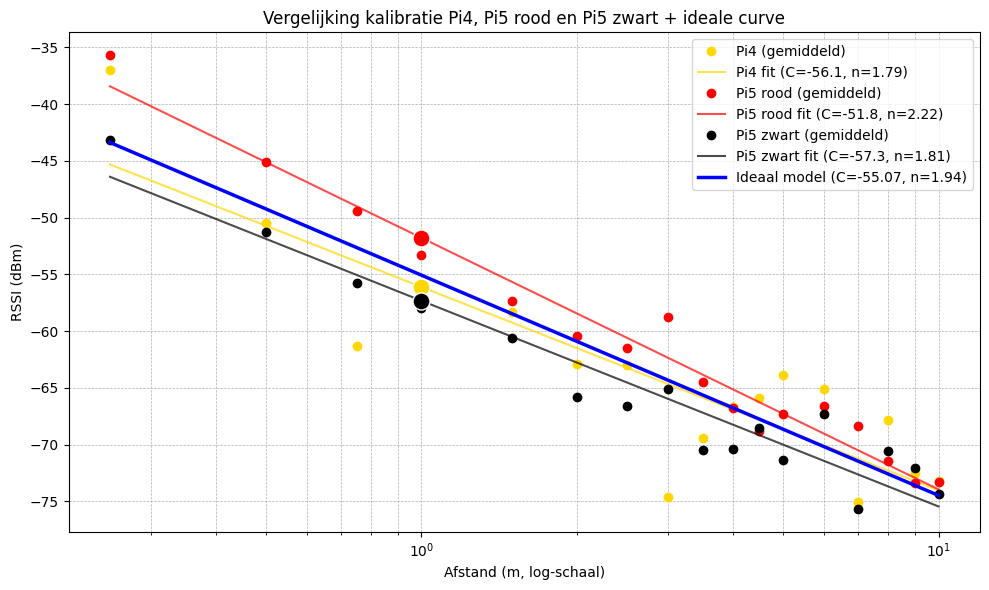

In [12]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit

def log_pathloss_model(d, C, n):
    return C - 10 * n * np.log10(d)

colors = {
    "Pi4": "gold",
    "Pi5 rood": "red",
    "Pi5 zwart": "black"
}

plt.figure(figsize=(10, 6))

alle_afstanden = []

for naam, df in data.items():

    grouped = df.groupby("dist_m")["rssi_dbm"].mean().reset_index()

    d = grouped["dist_m"].to_numpy()
    rssi = grouped["rssi_dbm"].to_numpy()

    # ❗ CORRECTE FILTER: verwijder d = 0
    mask = (~np.isnan(d)) & (d > 0)
    d = d[mask]
    rssi = rssi[mask]

    if len(d) < 2:
        print(f"{naam}: te weinig afstandspunten → overslaan")
        continue

    alle_afstanden.extend(list(d))

    popt, _ = curve_fit(log_pathloss_model, d, rssi, p0=[-40, 2])
    C_fit, n_fit = popt

    d_fit = np.logspace(np.log10(min(d)), np.log10(max(d)), 200)
    rssi_fit = log_pathloss_model(d_fit, C_fit, n_fit)

    plt.plot(d, rssi, 'o', color=colors[naam], label=f'{naam} (gemiddeld)')
    plt.plot(d_fit, rssi_fit, '-', color=colors[naam], alpha=0.7,
             label=f'{naam} fit (C={C_fit:.1f}, n={n_fit:.2f})')

    plt.scatter(1, C_fit, color=colors[naam], edgecolor='white', s=150, zorder=5)

# Ideale curve
C_ideal = params['combined']['C_intercept']
n_ideal = params['combined']['path_loss_n']

d_range = np.logspace(
    np.log10(min(alle_afstanden)),
    np.log10(max(alle_afstanden)),
    300
)

rssi_ideal = log_pathloss_model(d_range, C_ideal, n_ideal)

plt.plot(
    d_range,
    rssi_ideal,
    color='blue',
    linewidth=2.5,
    label=f"Ideaal model (C={C_ideal:.2f}, n={n_ideal:.2f})"
)

plt.xscale('log')
plt.xlabel('Afstand (m, log-schaal)')
plt.ylabel('RSSI (dBm)')
plt.title('Vergelijking kalibratie Pi4, Pi5 rood en Pi5 zwart + ideale curve')
plt.grid(True, which="both", ls="--", lw=0.5)
plt.legend()
plt.tight_layout()
plt.show()


Statistiek 


   AFSTAND = 0.25 meter


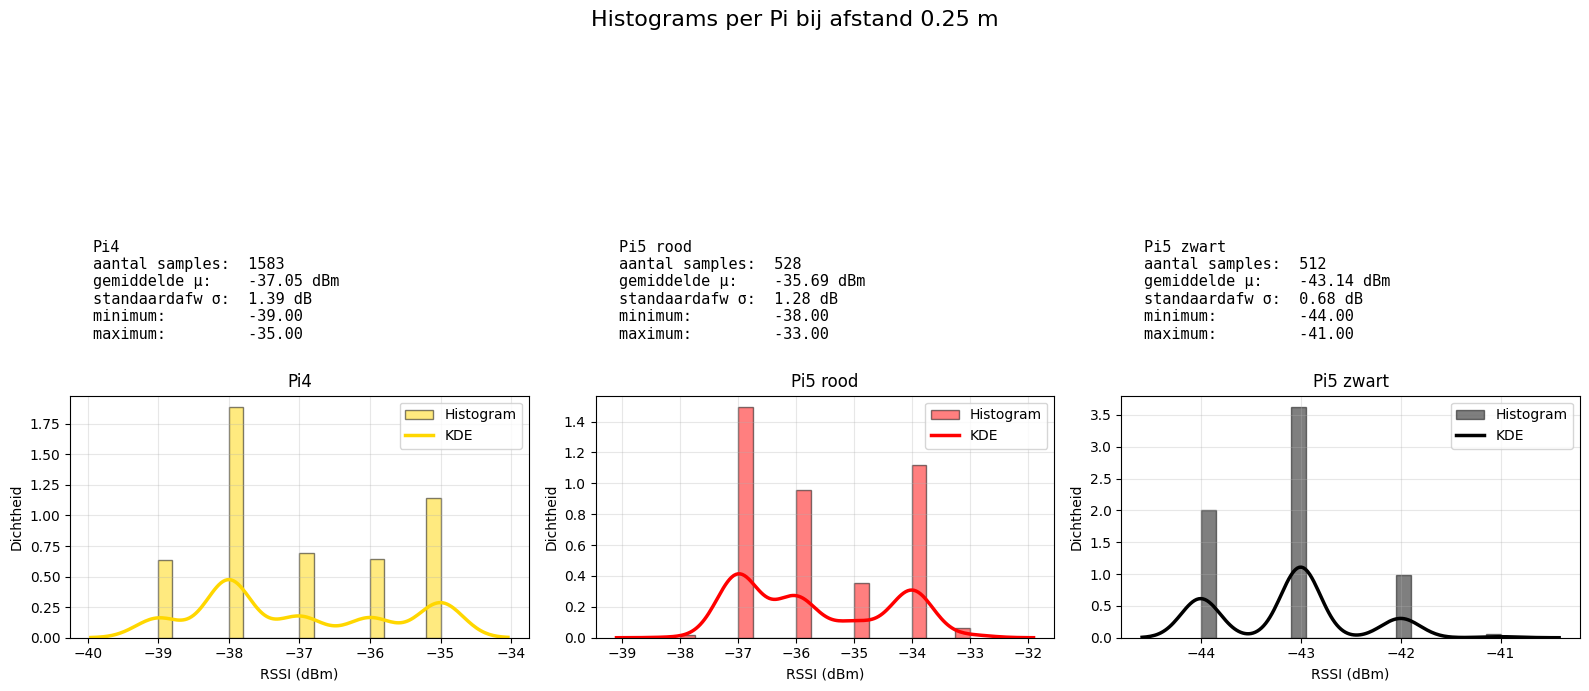


   AFSTAND = 0.5 meter


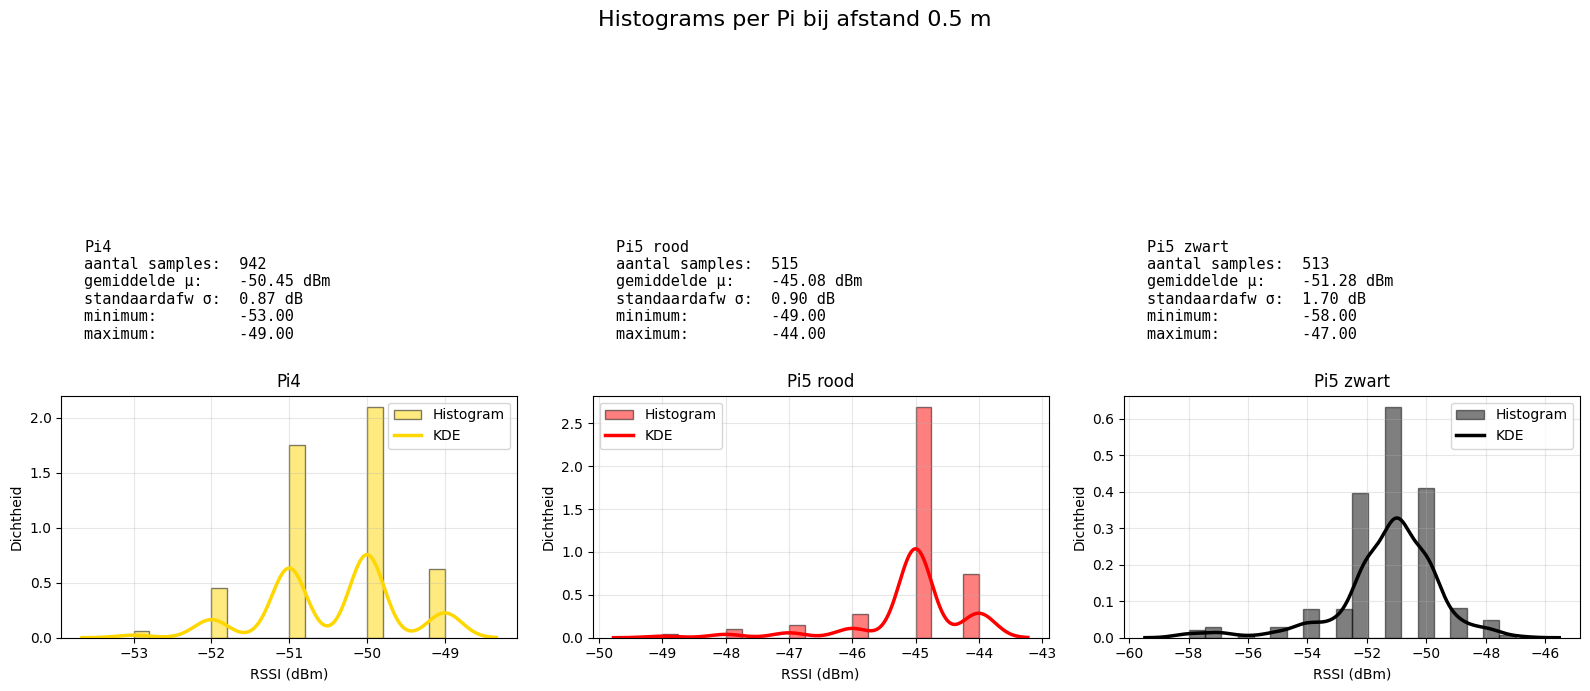


   AFSTAND = 0.75 meter


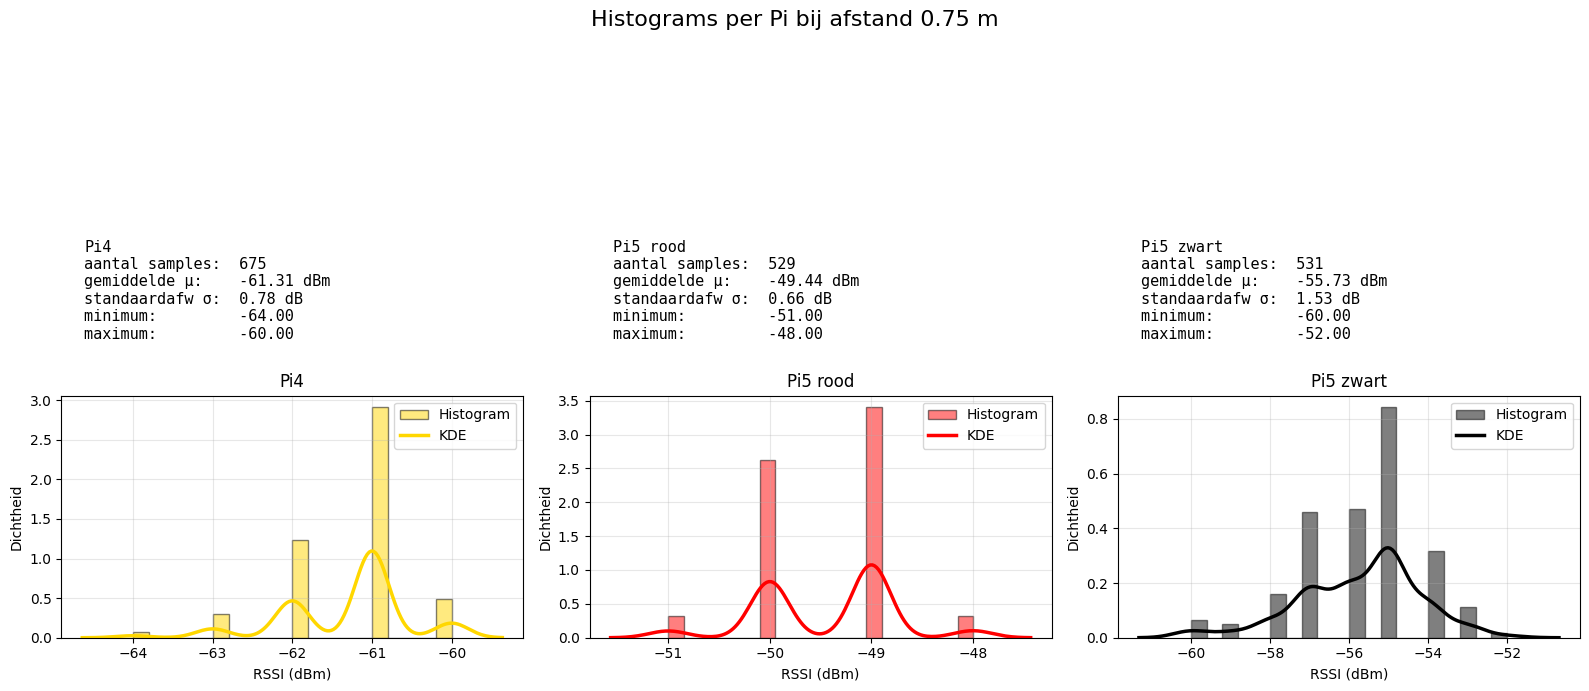


   AFSTAND = 1.0 meter


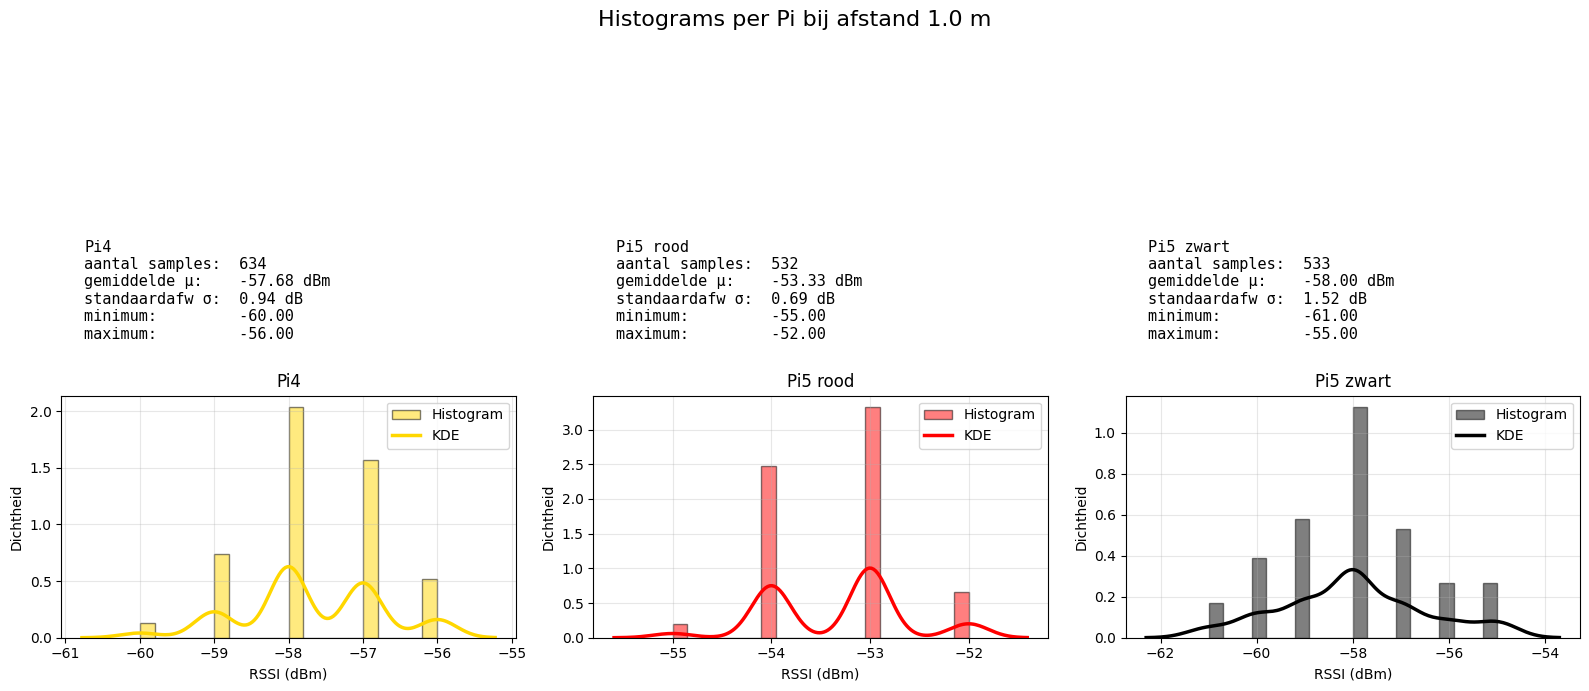


   AFSTAND = 1.5 meter


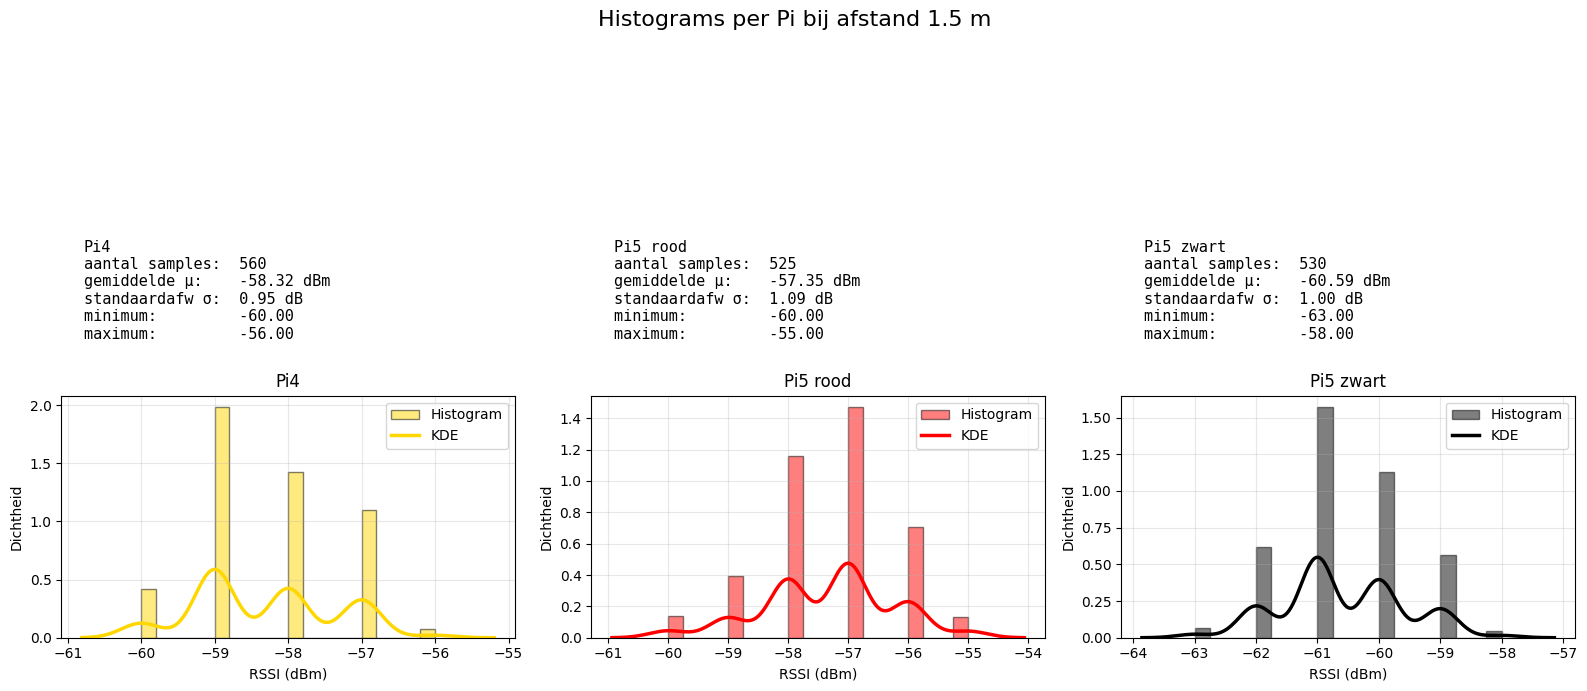


   AFSTAND = 2.0 meter


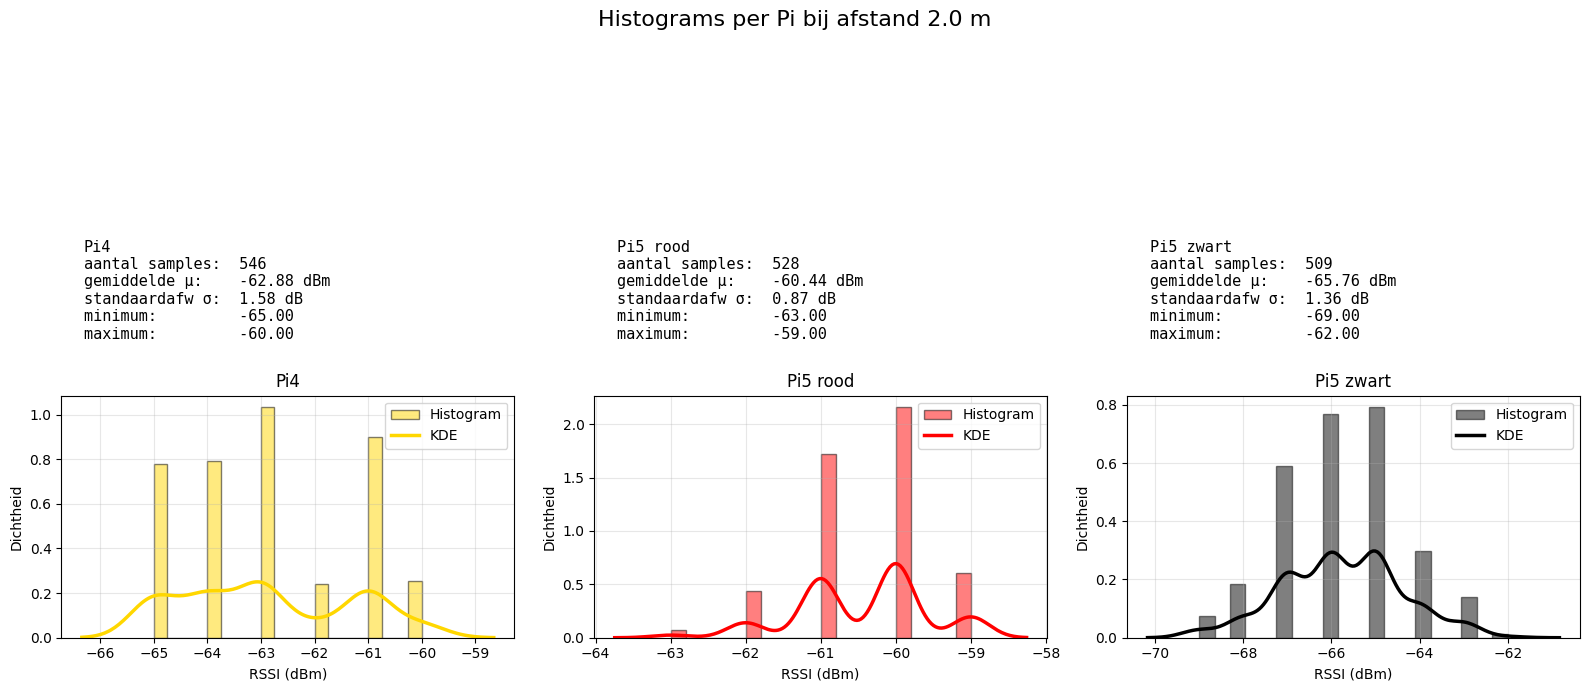


   AFSTAND = 2.5 meter


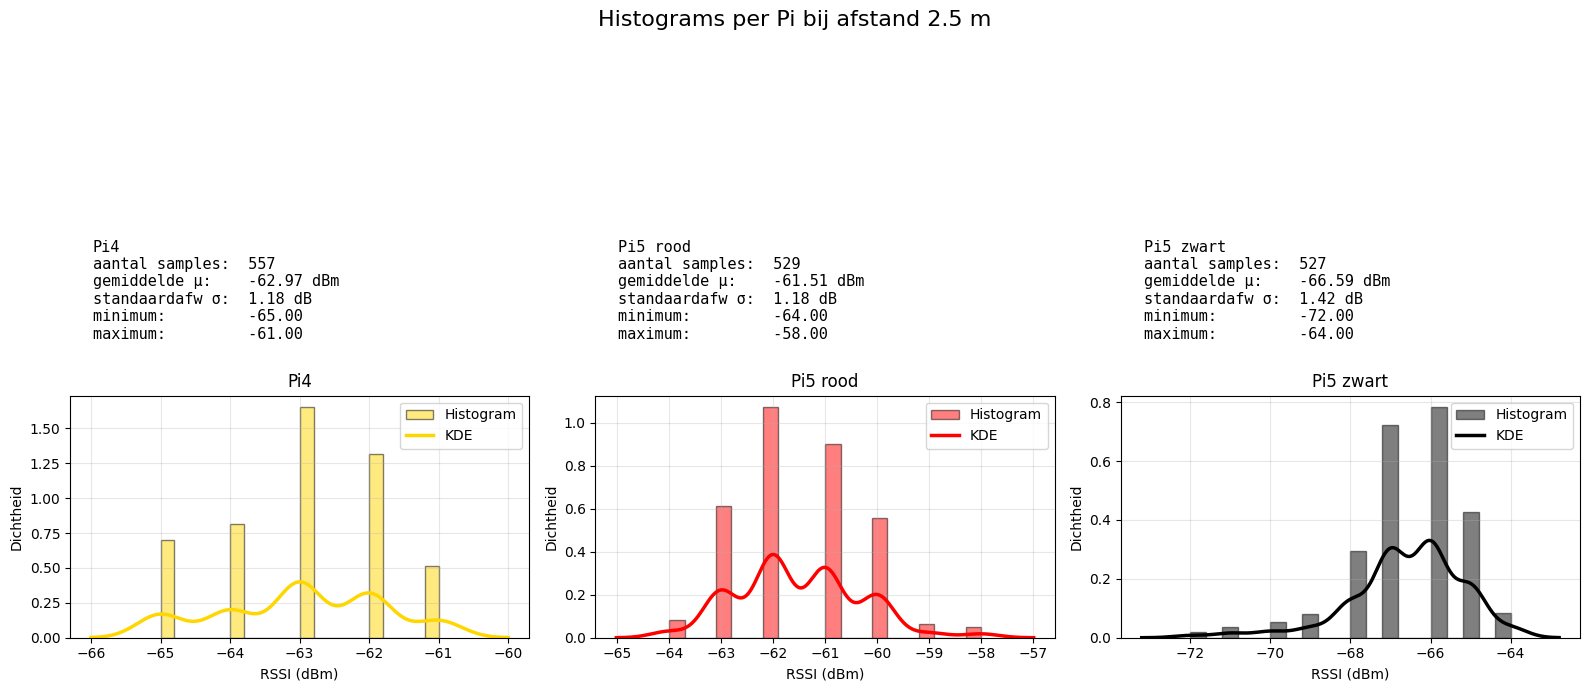


   AFSTAND = 3.0 meter


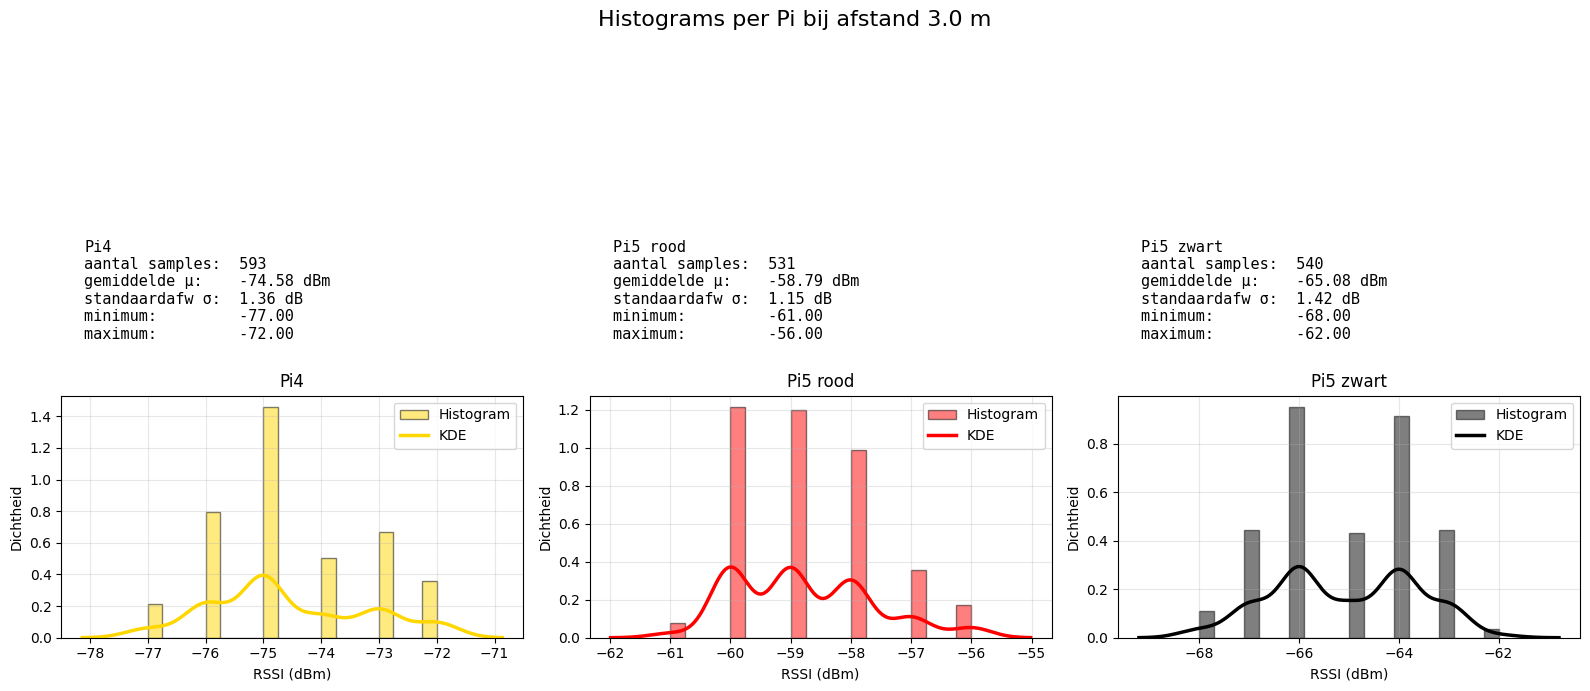


   AFSTAND = 3.5 meter


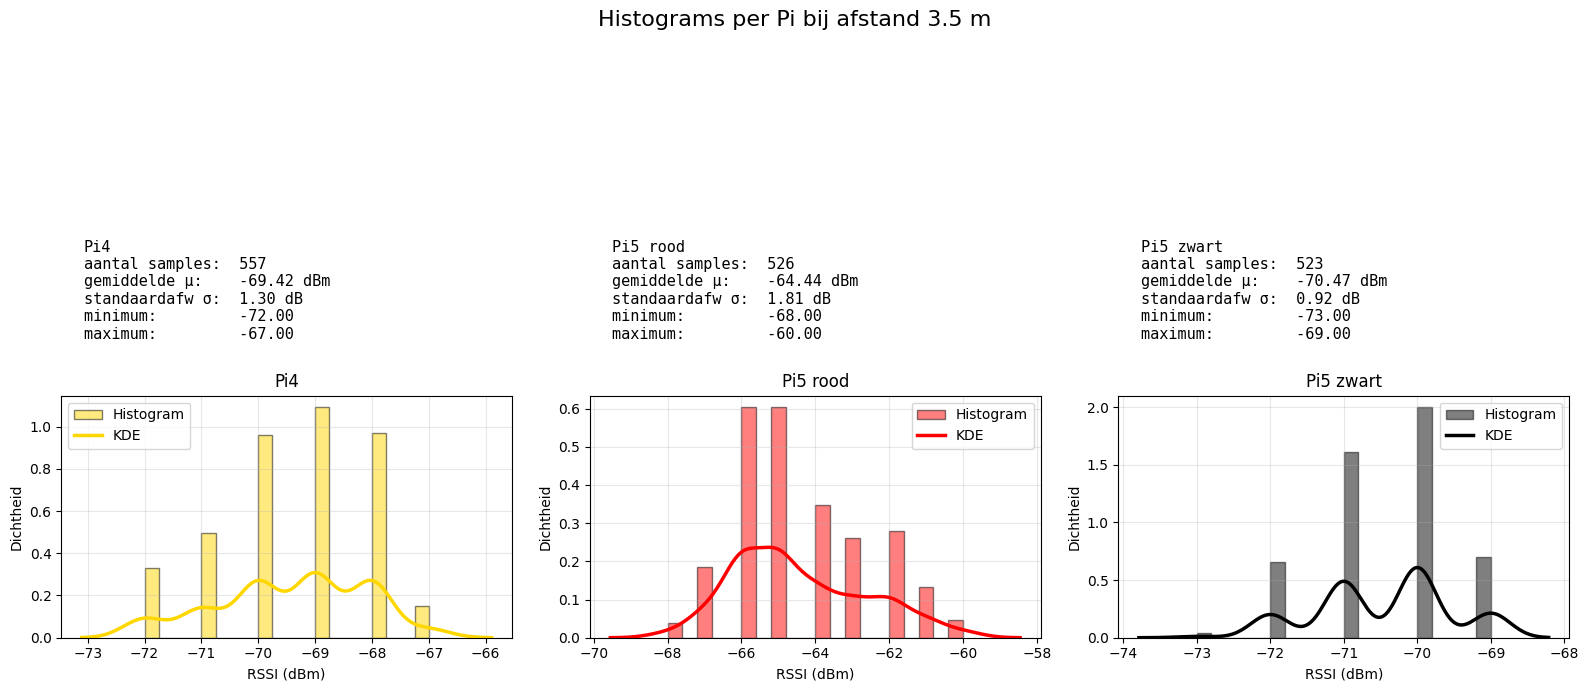


   AFSTAND = 4.0 meter


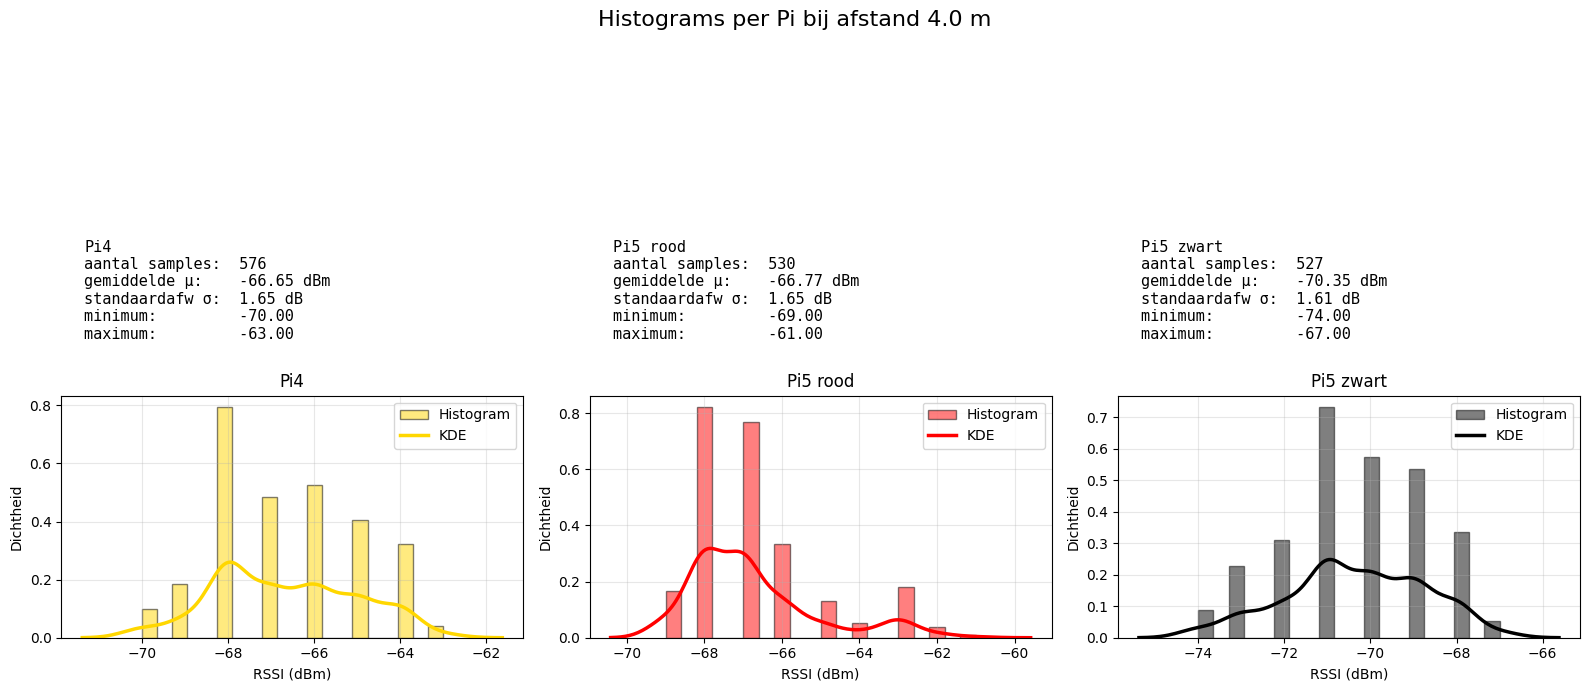


   AFSTAND = 4.5 meter


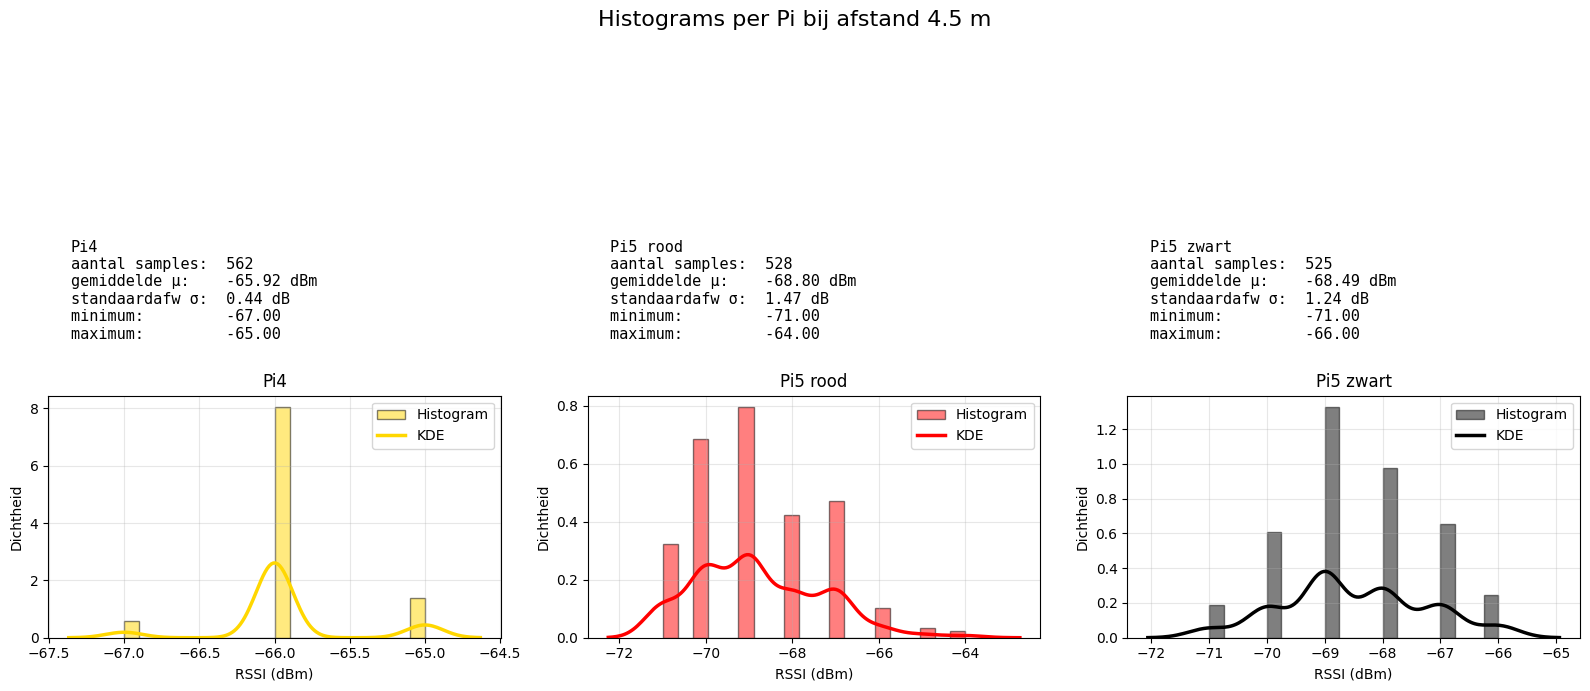


   AFSTAND = 5.0 meter


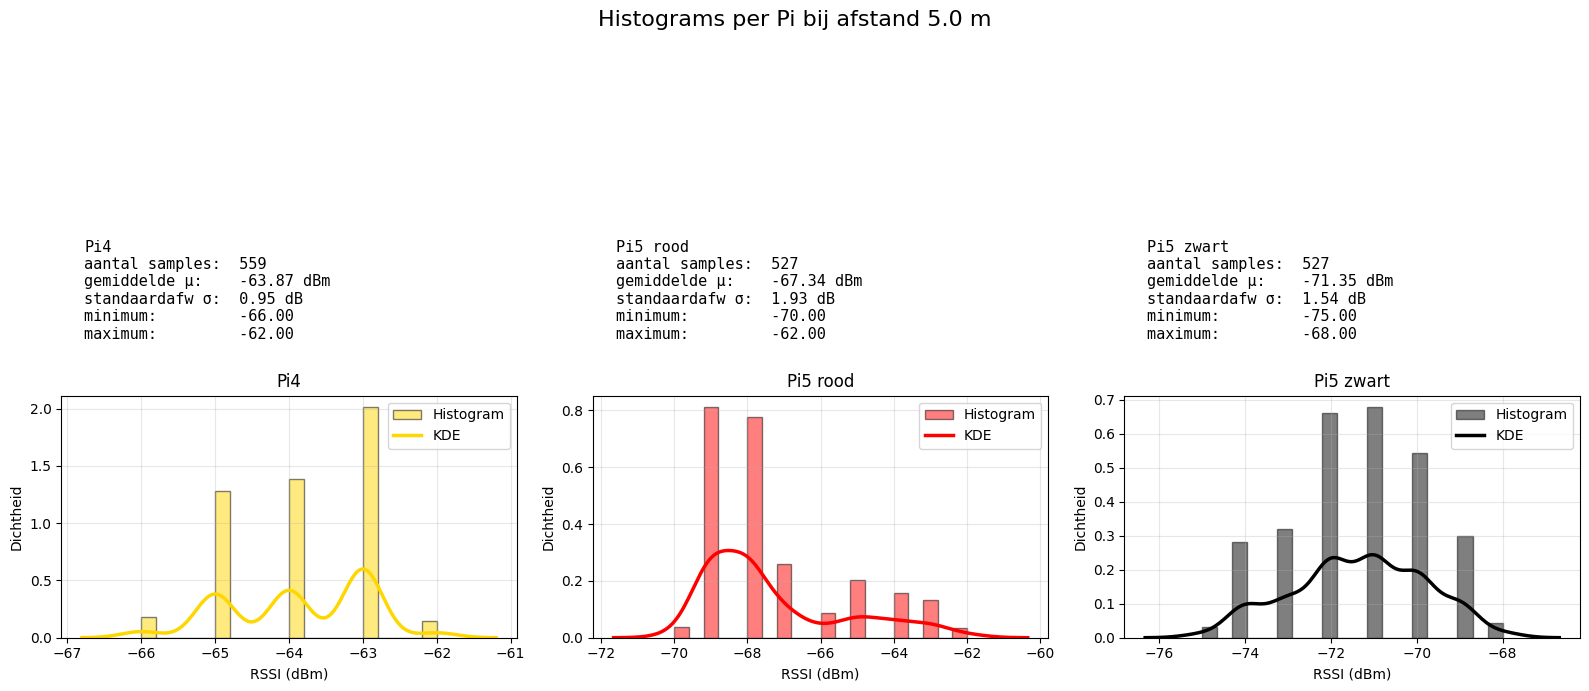


   AFSTAND = 6.0 meter


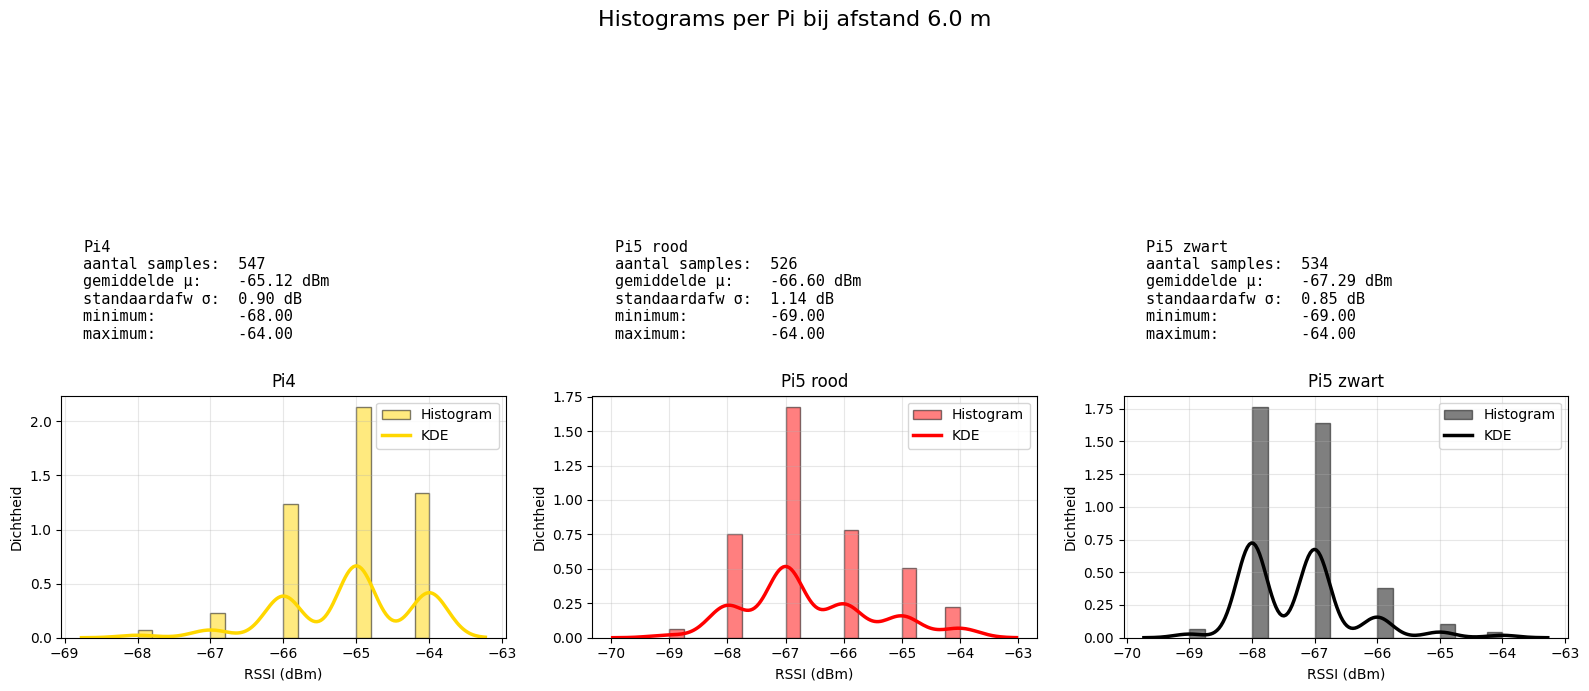


   AFSTAND = 7.0 meter


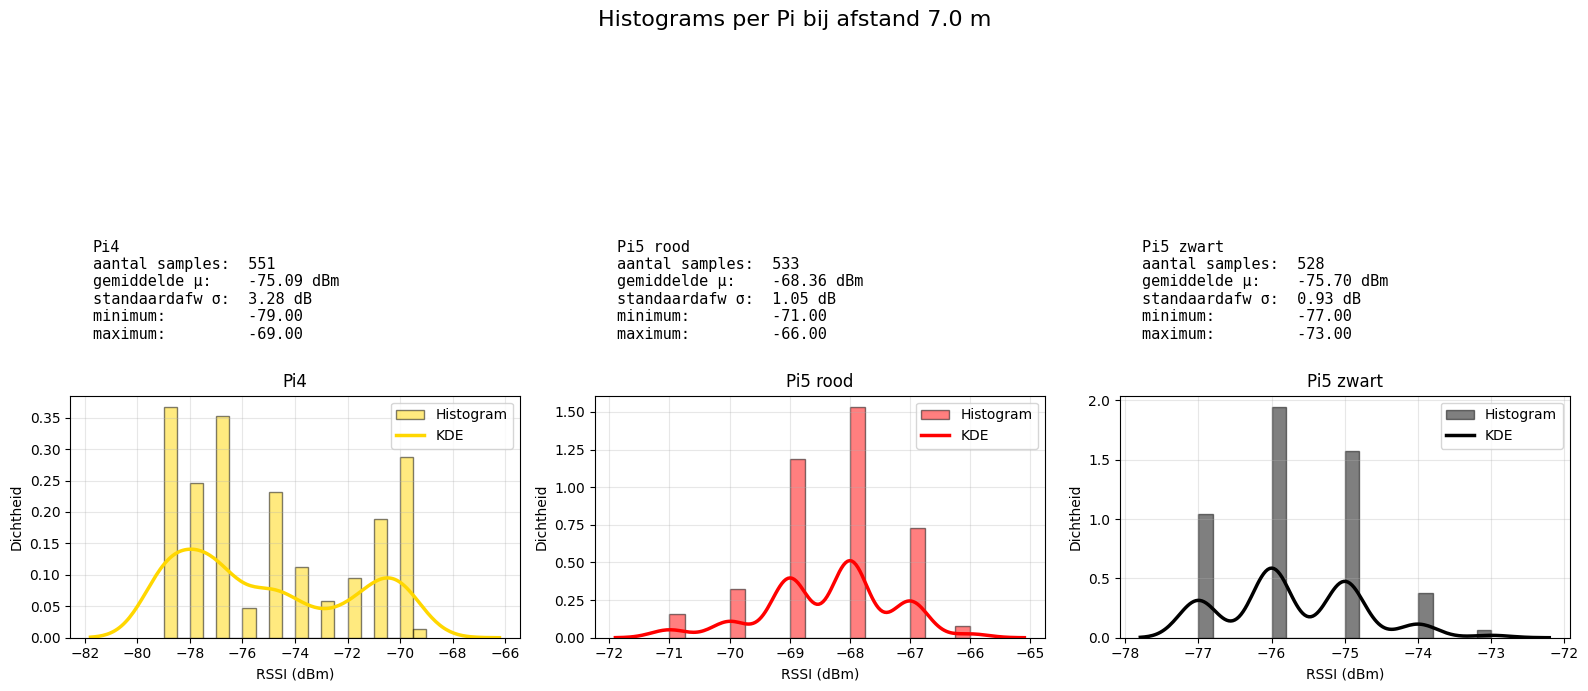


   AFSTAND = 8.0 meter


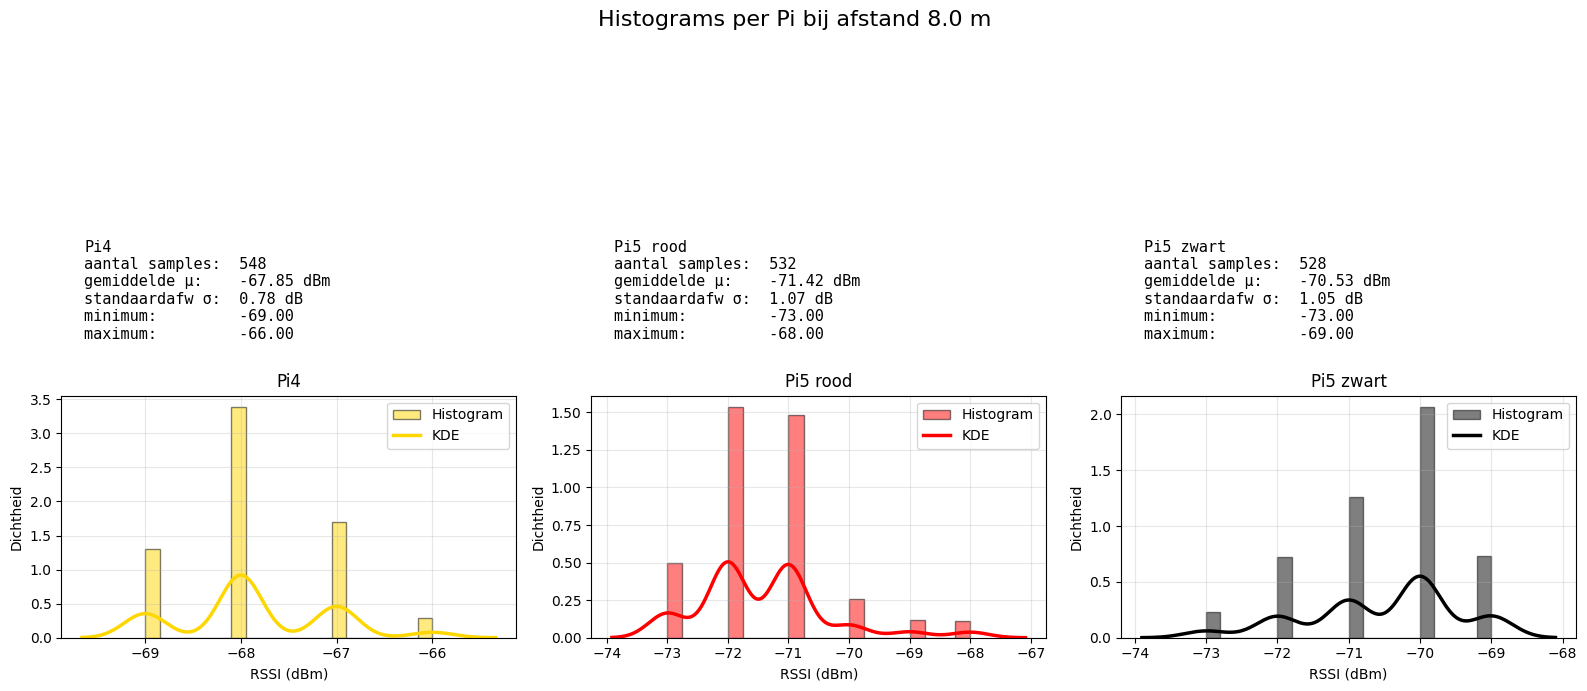


   AFSTAND = 9.0 meter


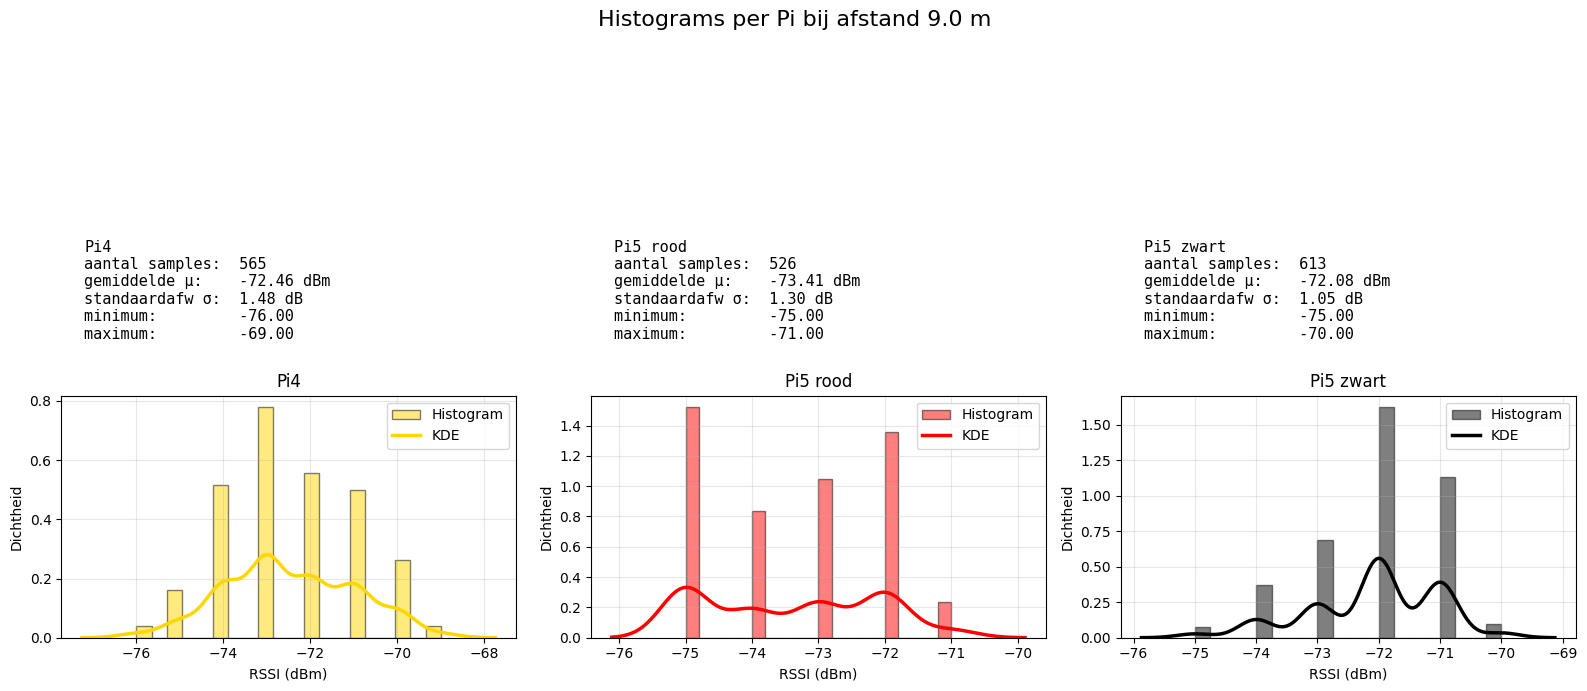


   AFSTAND = 10.0 meter


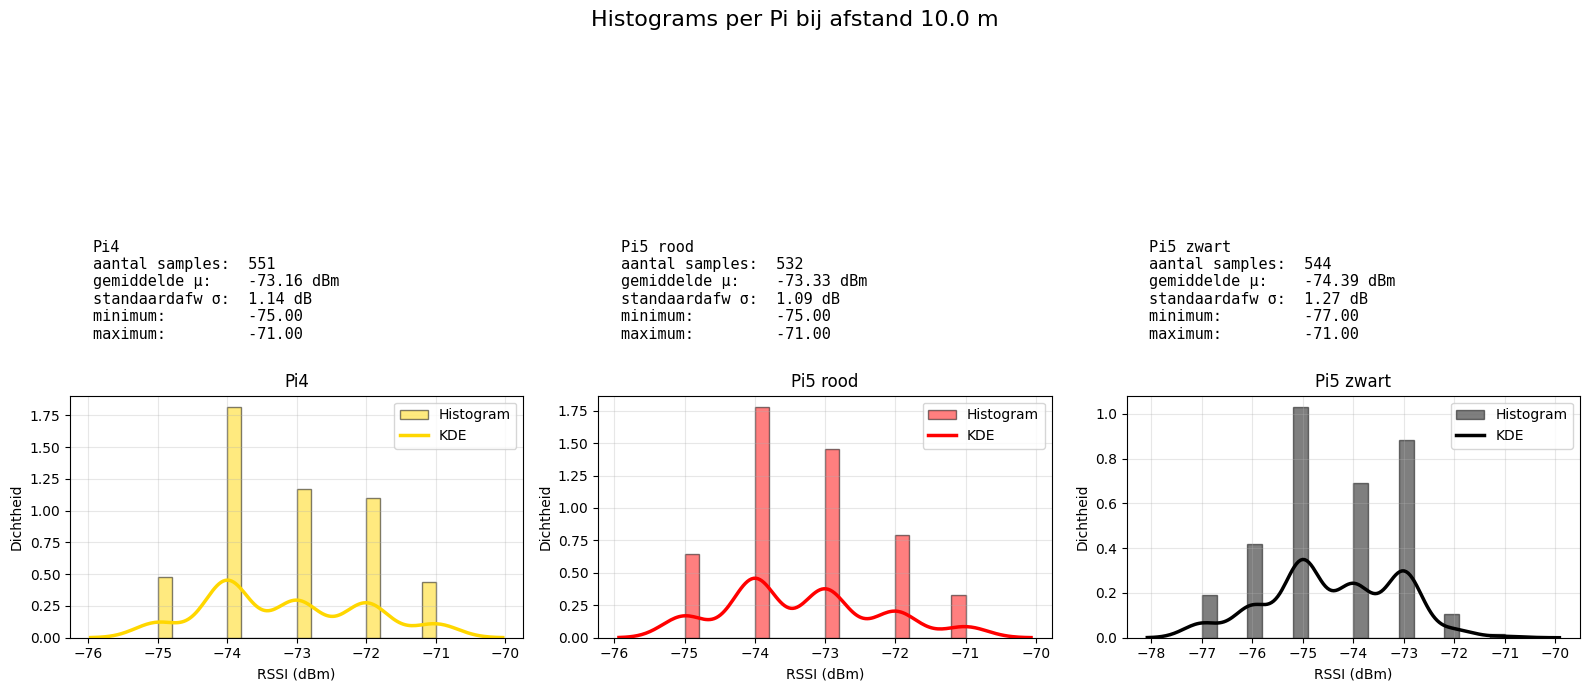


   AFSTAND = 0.25 meter


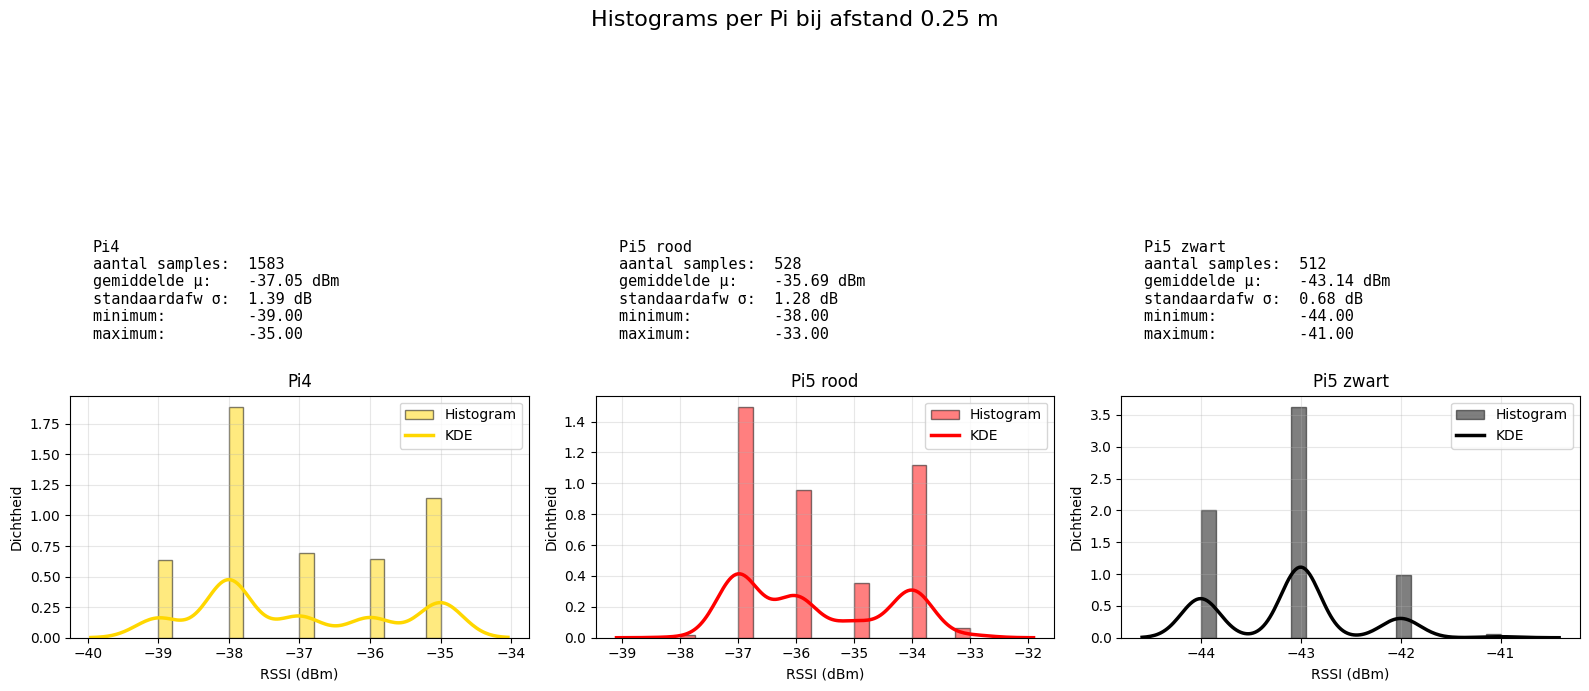


   AFSTAND = 0.5 meter


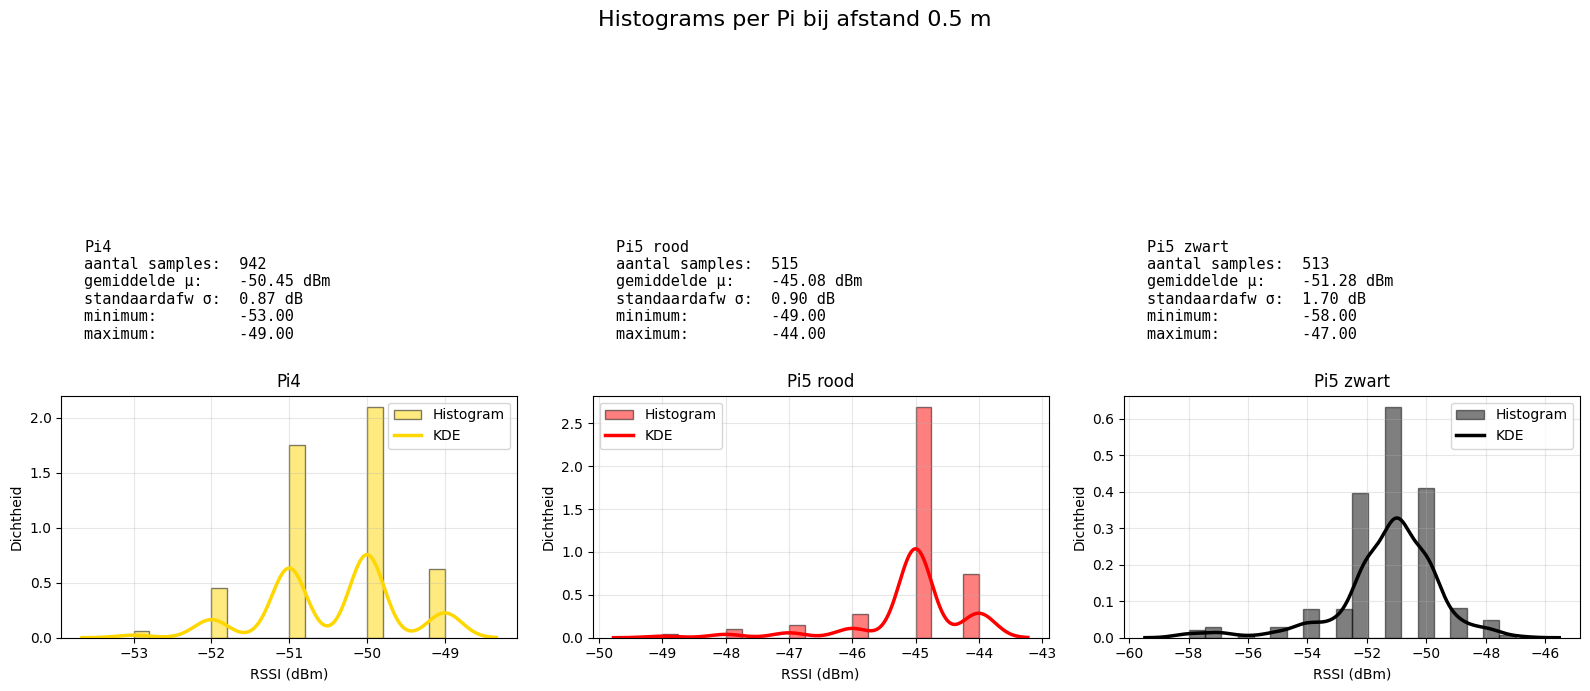


   AFSTAND = 0.75 meter


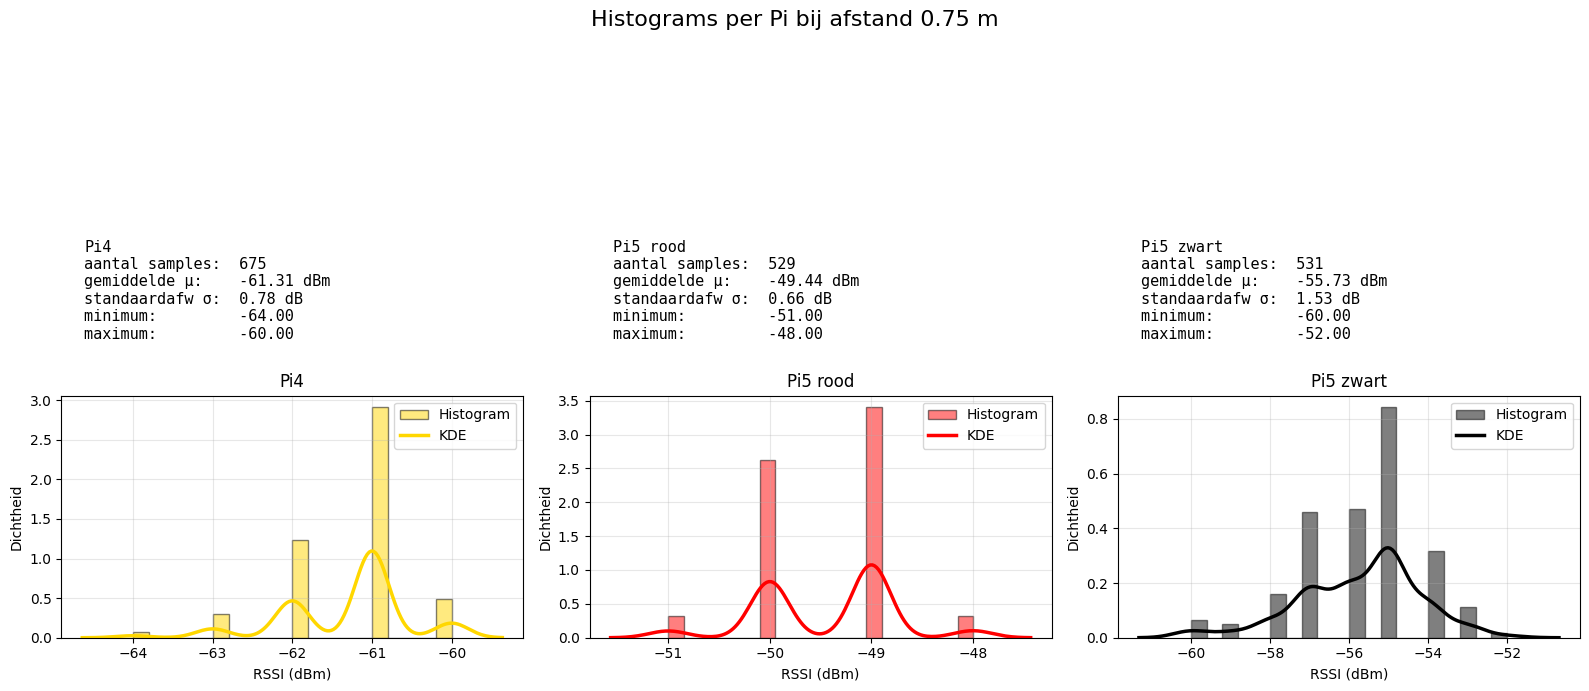


   AFSTAND = 1.0 meter


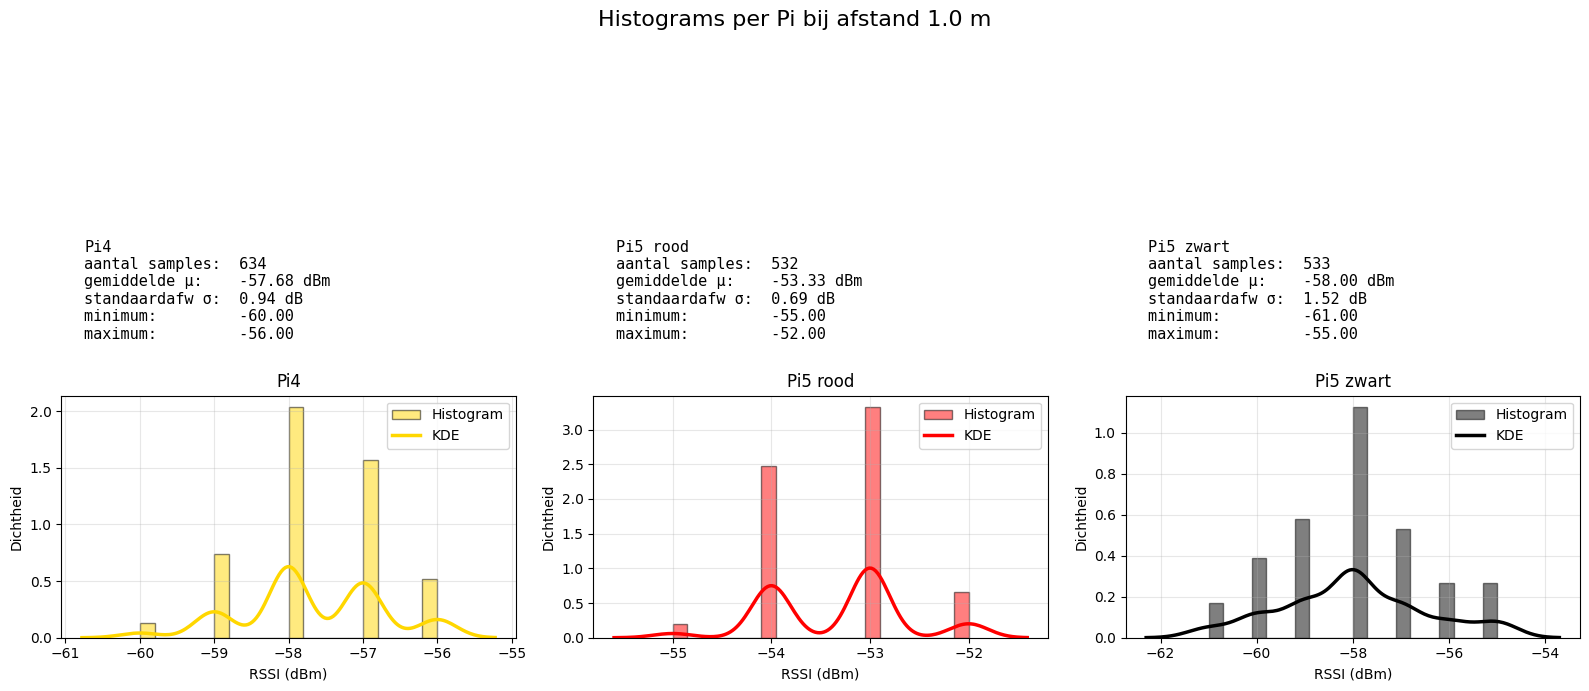


   AFSTAND = 1.5 meter


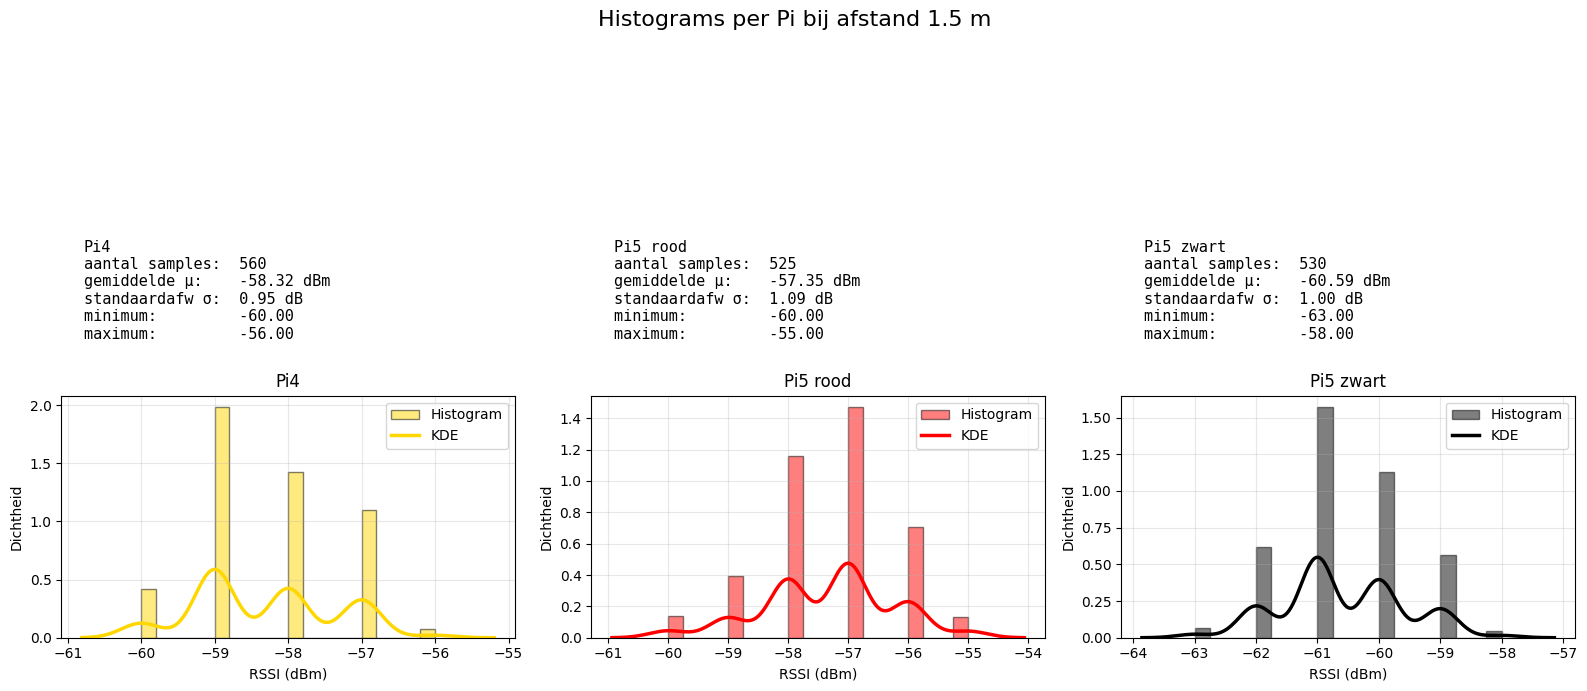


   AFSTAND = 2.0 meter


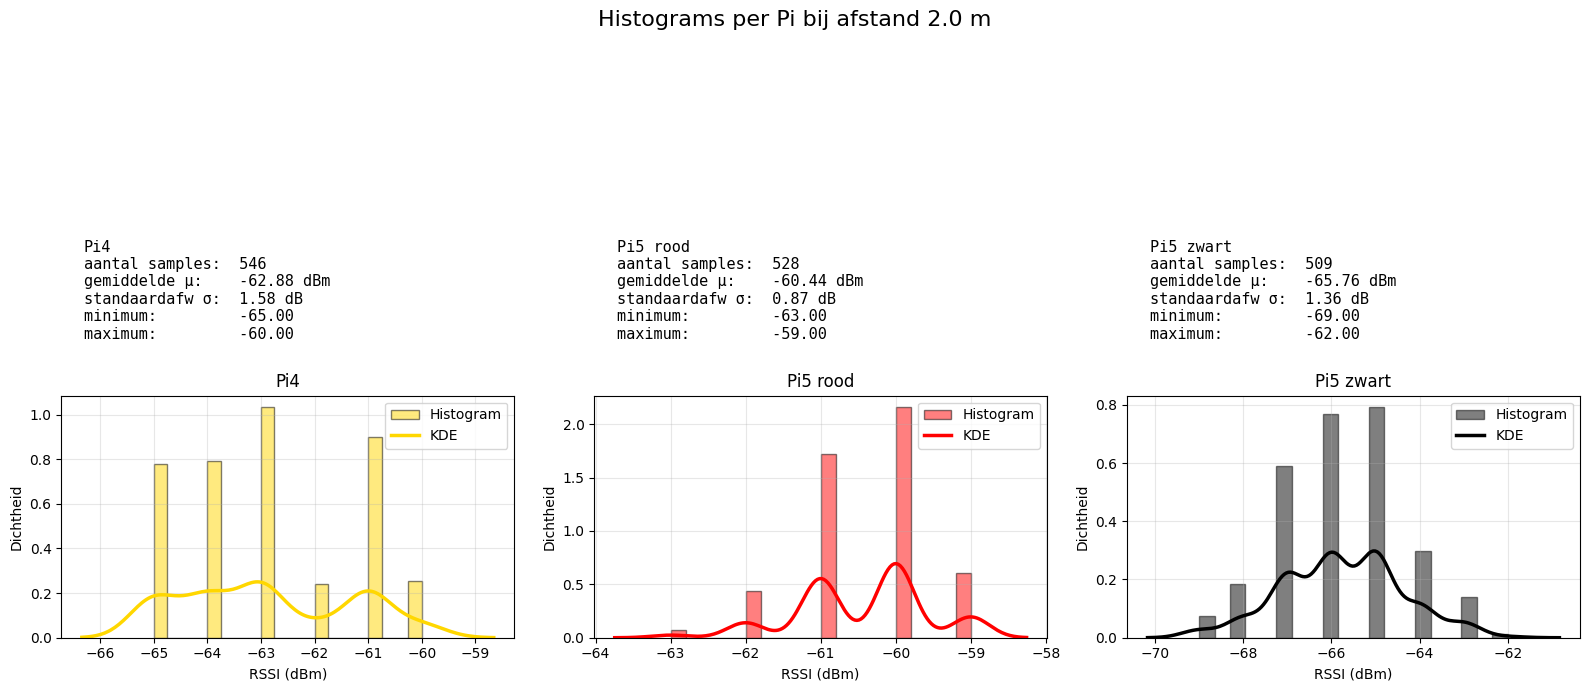


   AFSTAND = 2.5 meter


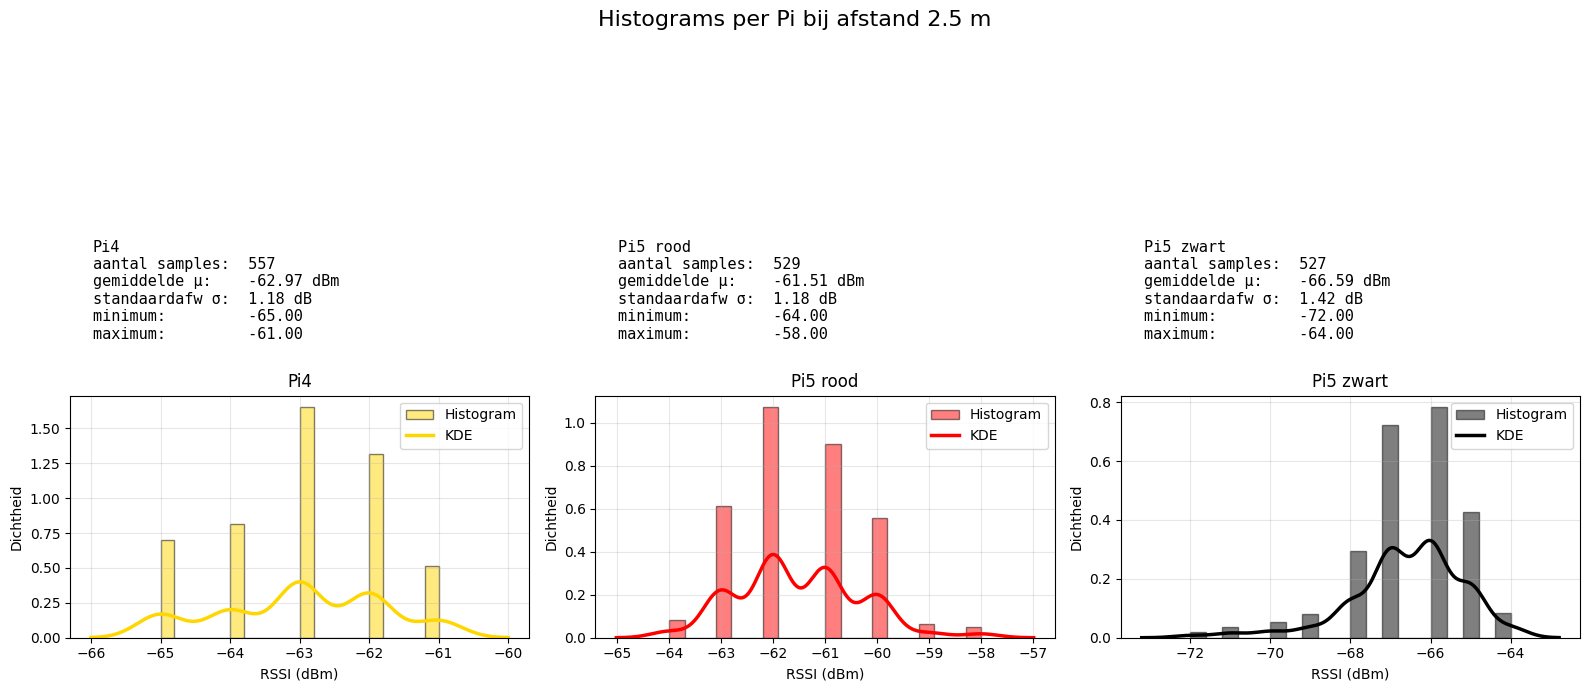


   AFSTAND = 3.0 meter


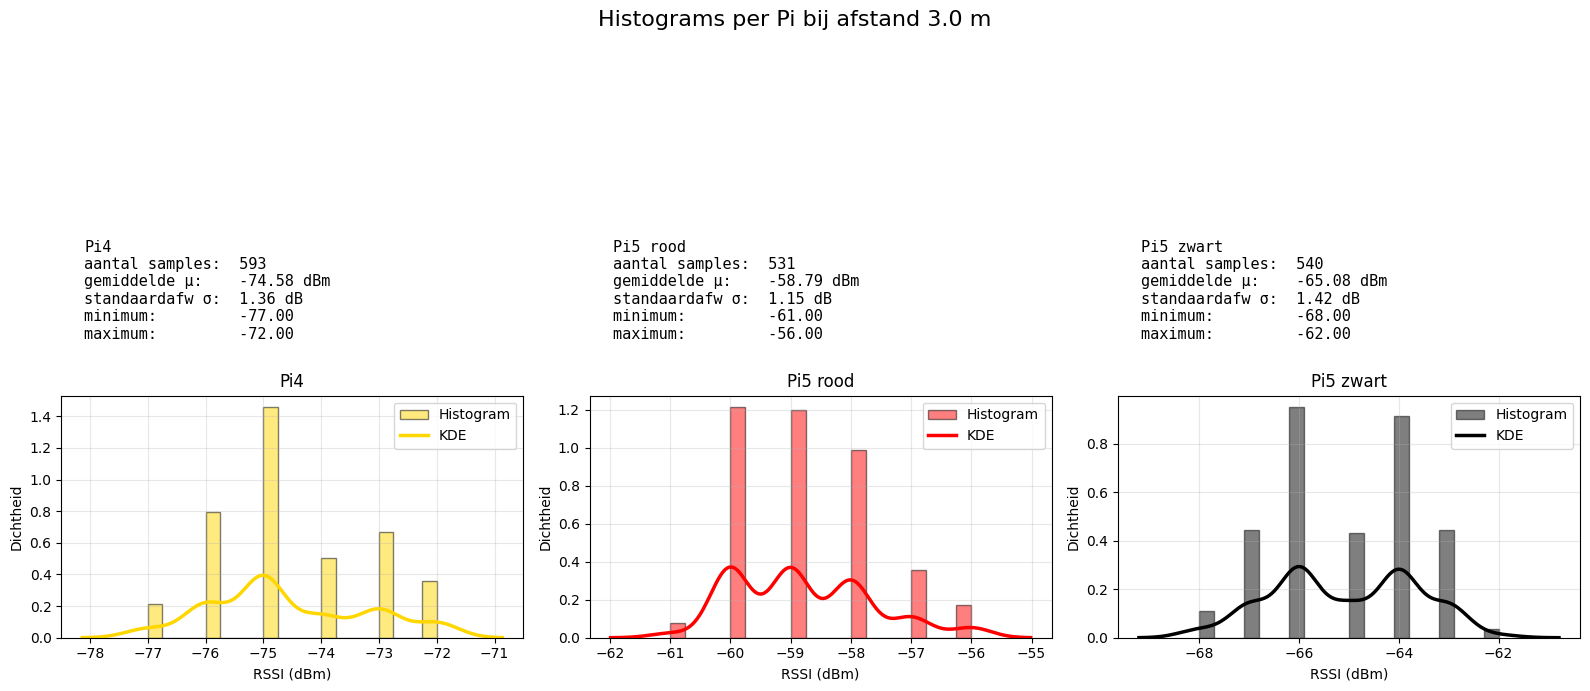


   AFSTAND = 3.5 meter


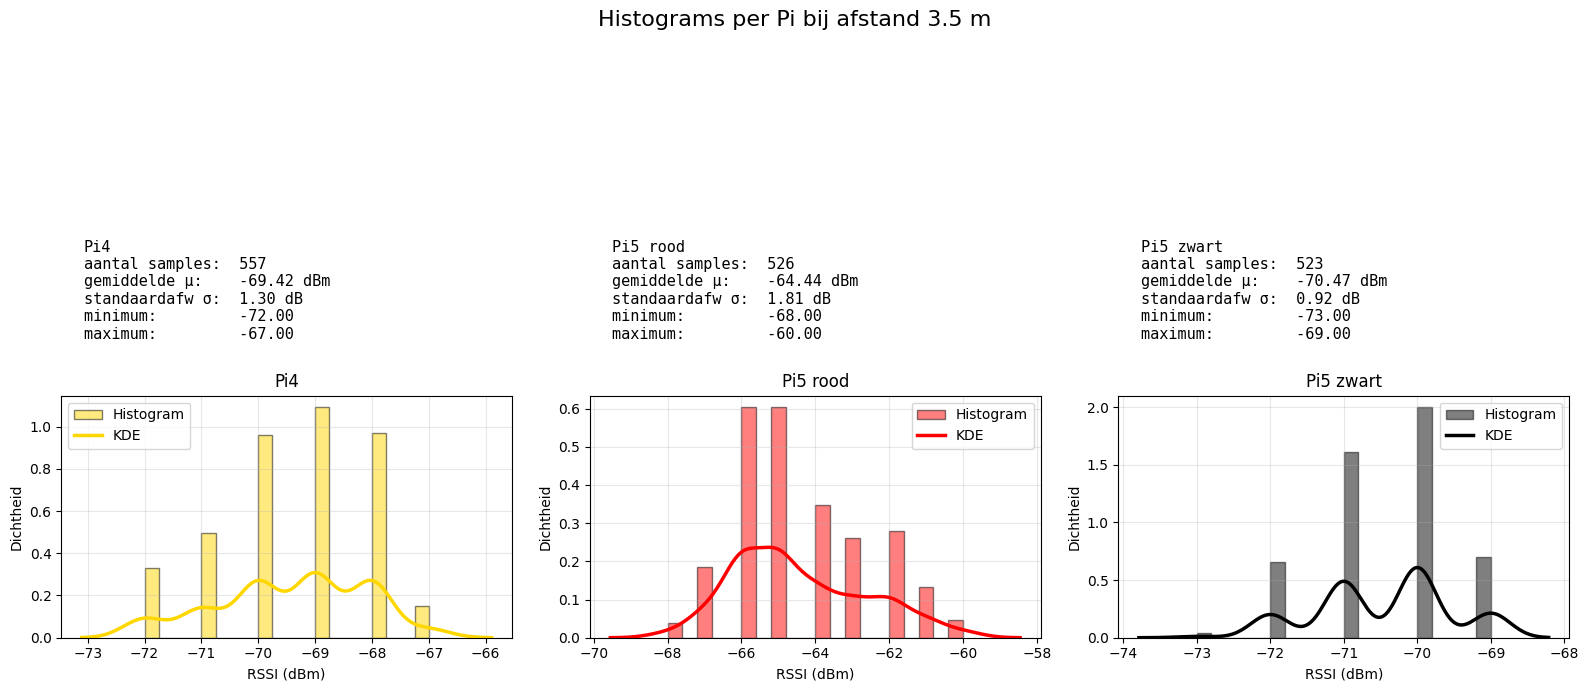


   AFSTAND = 4.0 meter


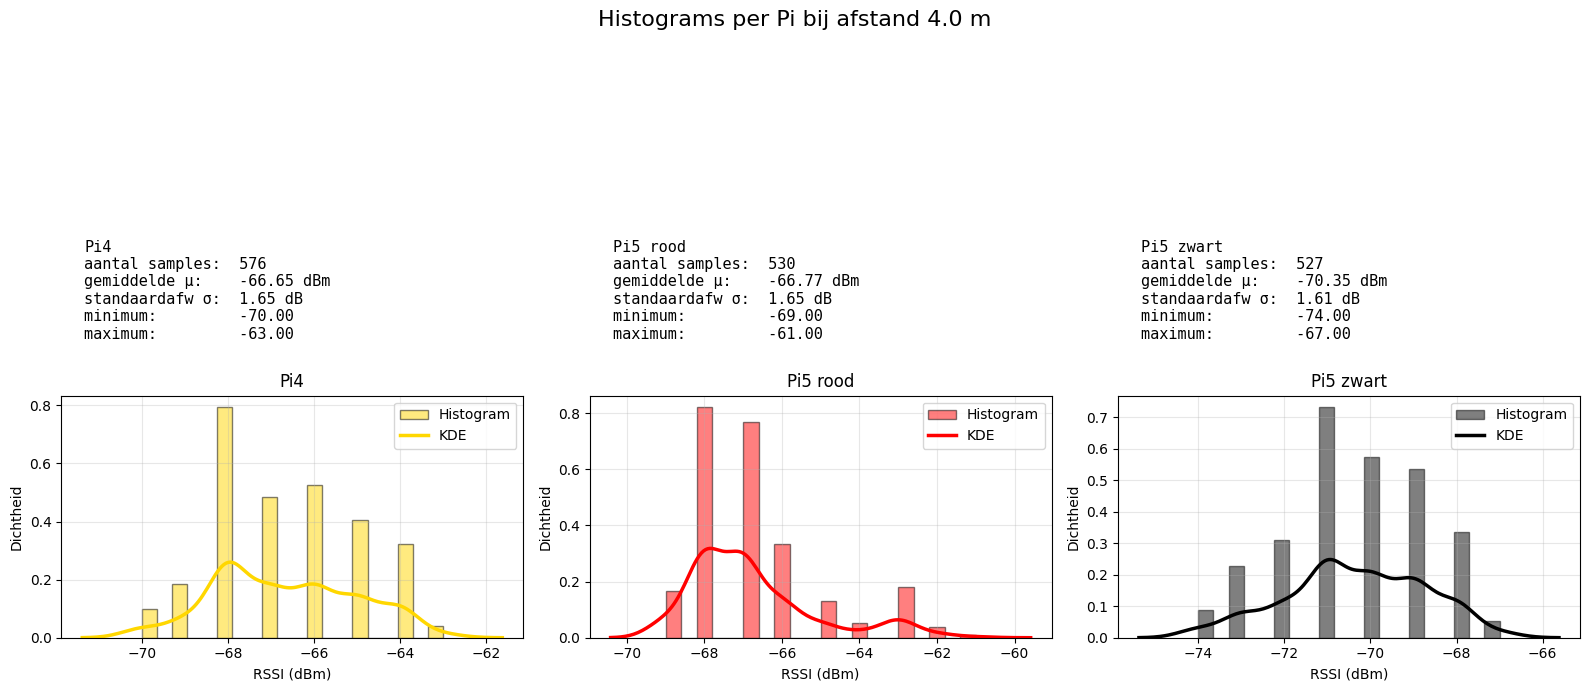


   AFSTAND = 4.5 meter


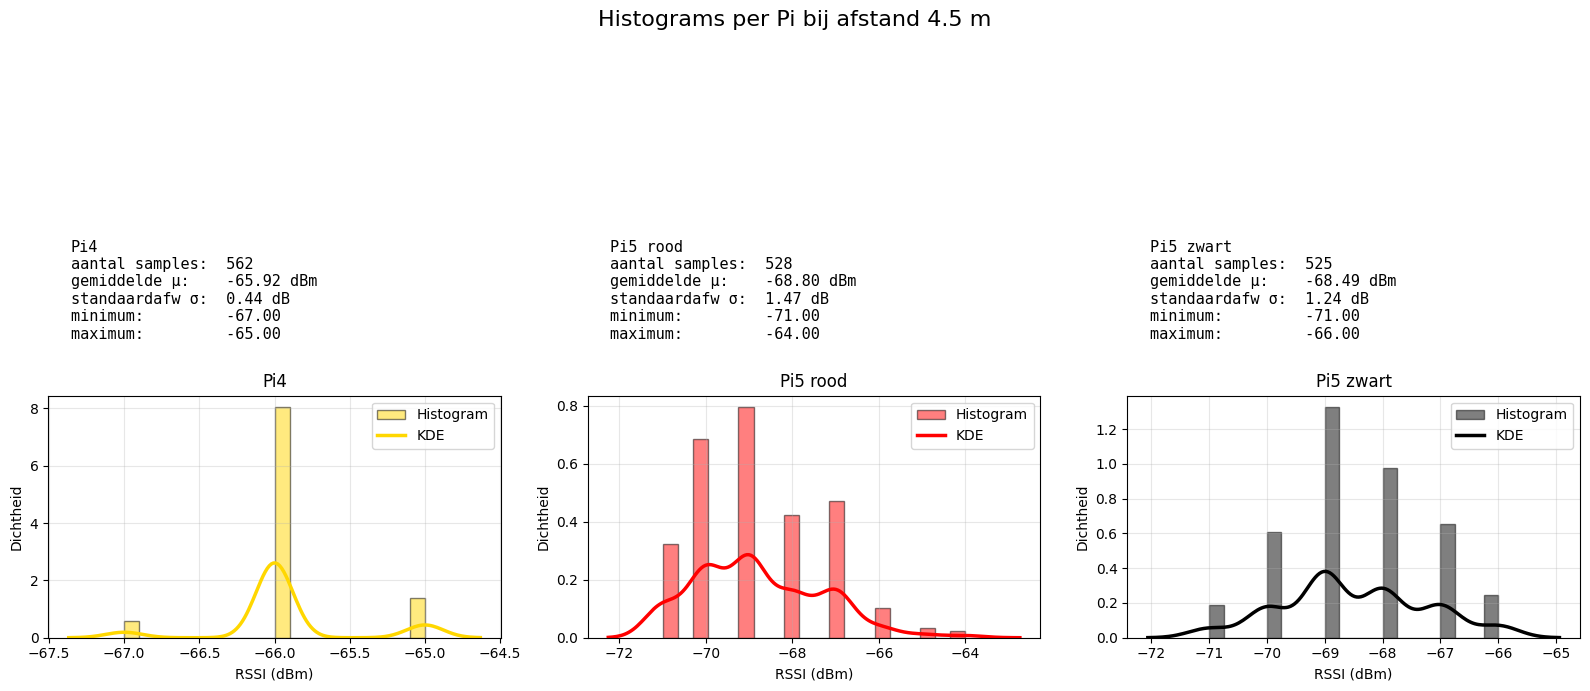


   AFSTAND = 5.0 meter


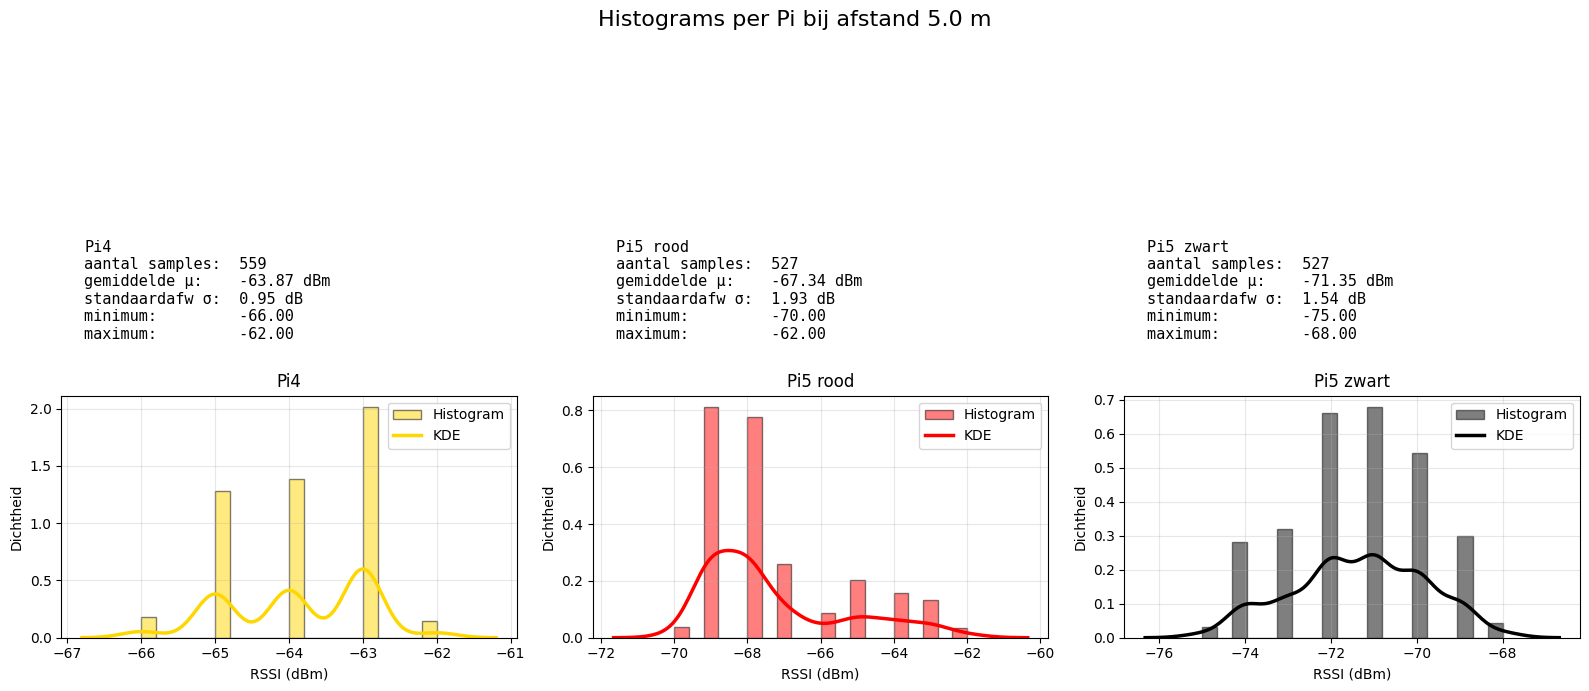


   AFSTAND = 6.0 meter


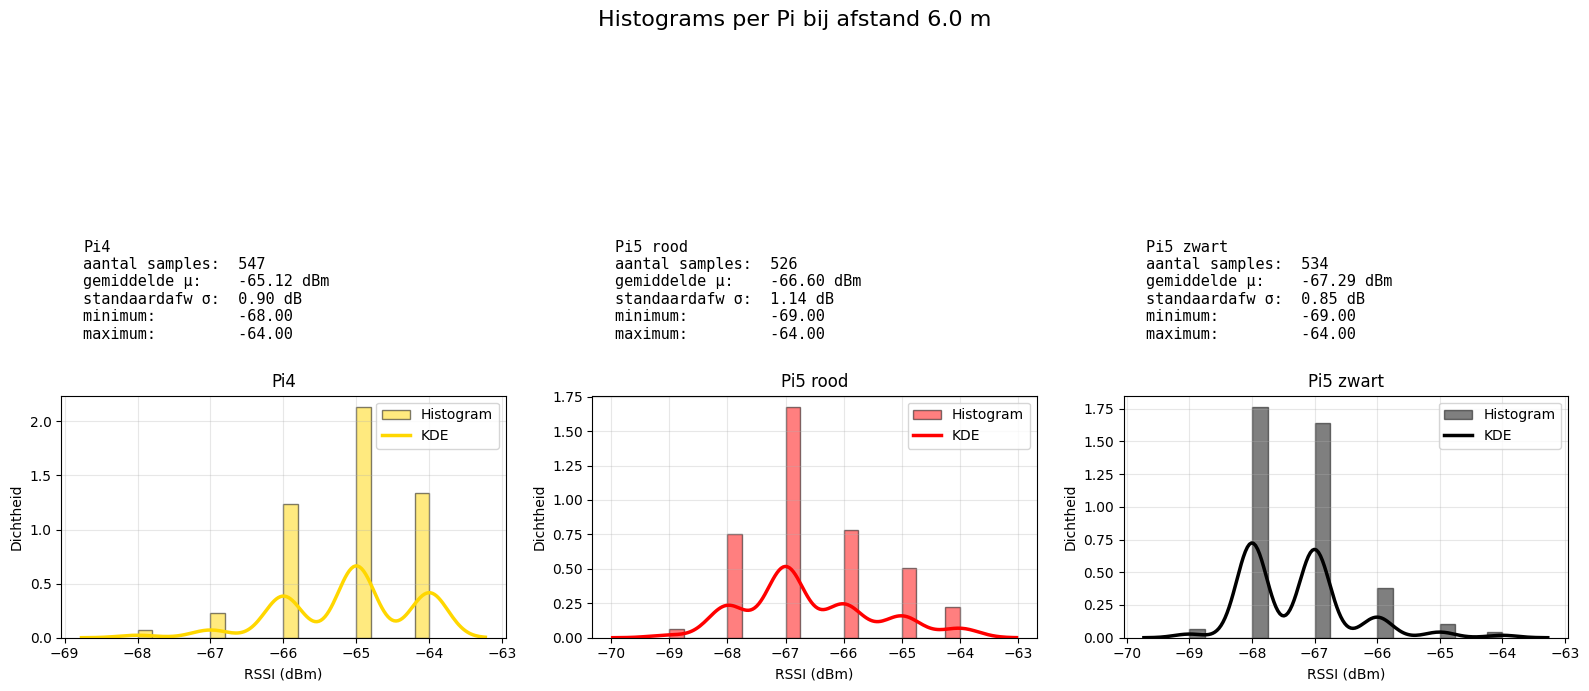


   AFSTAND = 7.0 meter


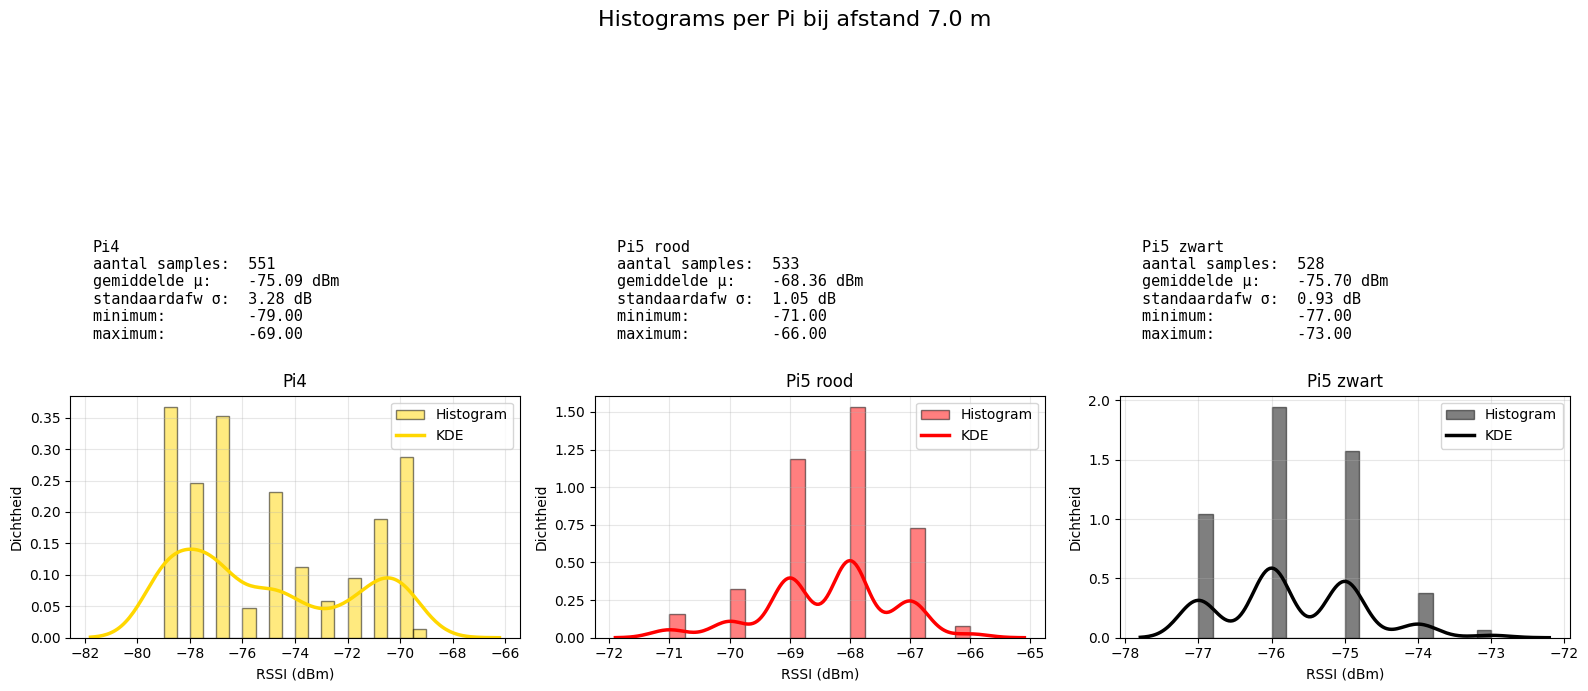


   AFSTAND = 8.0 meter


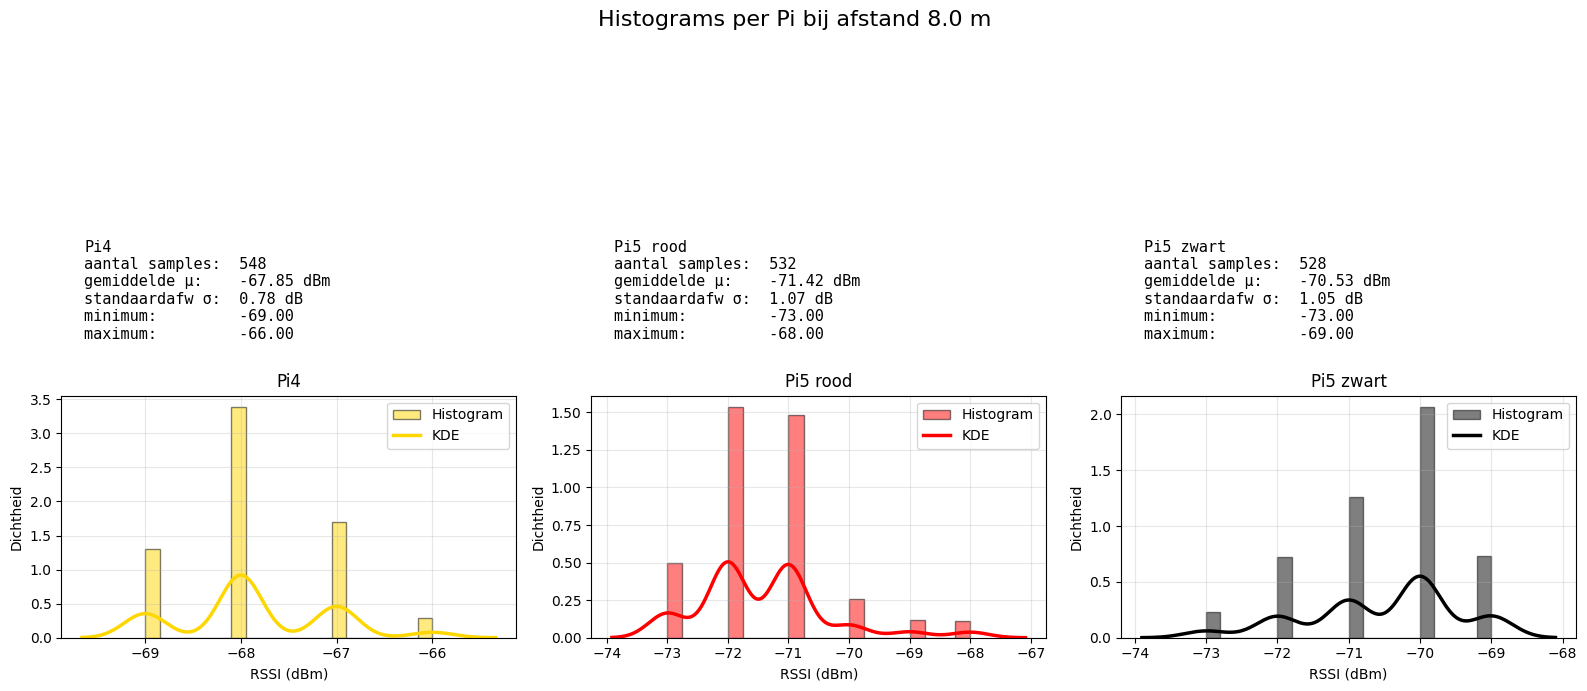


   AFSTAND = 9.0 meter


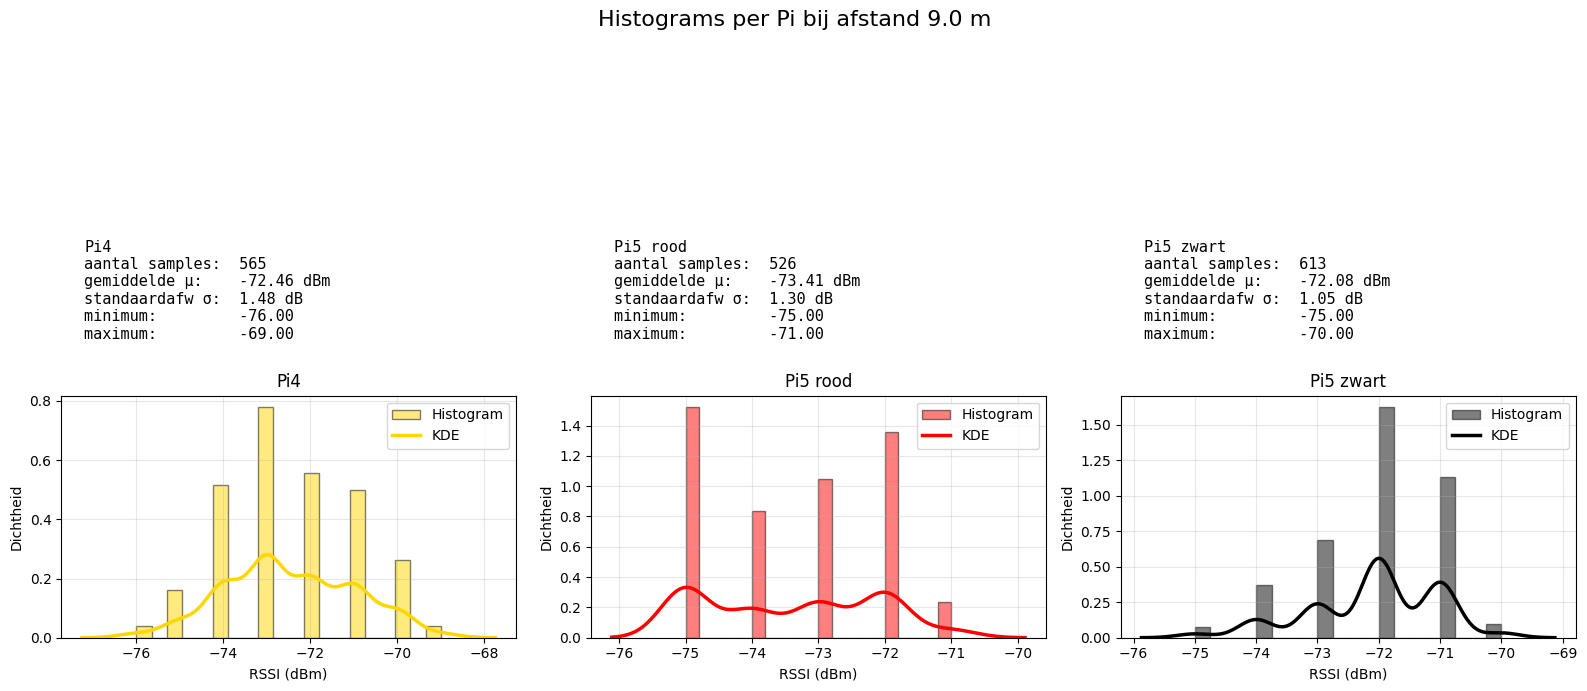


   AFSTAND = 10.0 meter


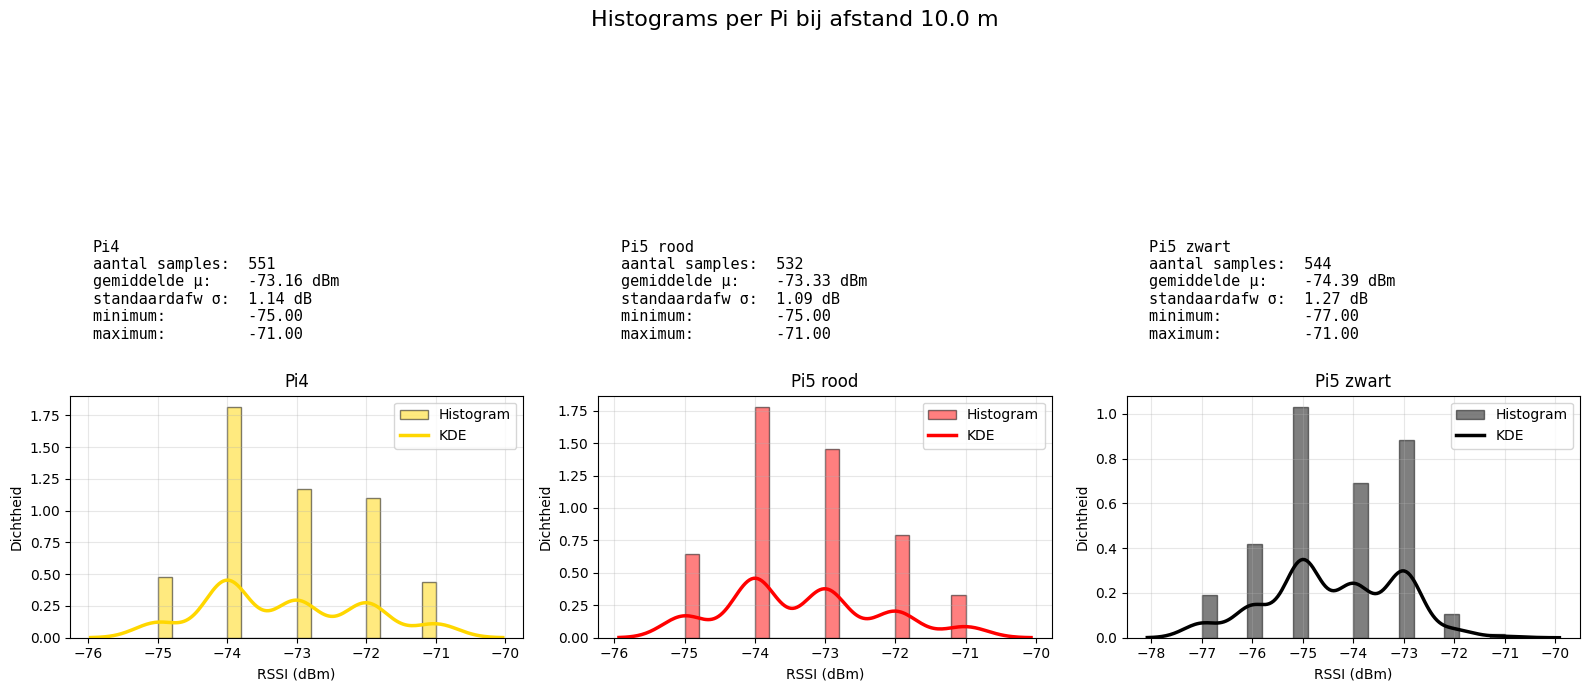


   AFSTAND = 0.25 meter


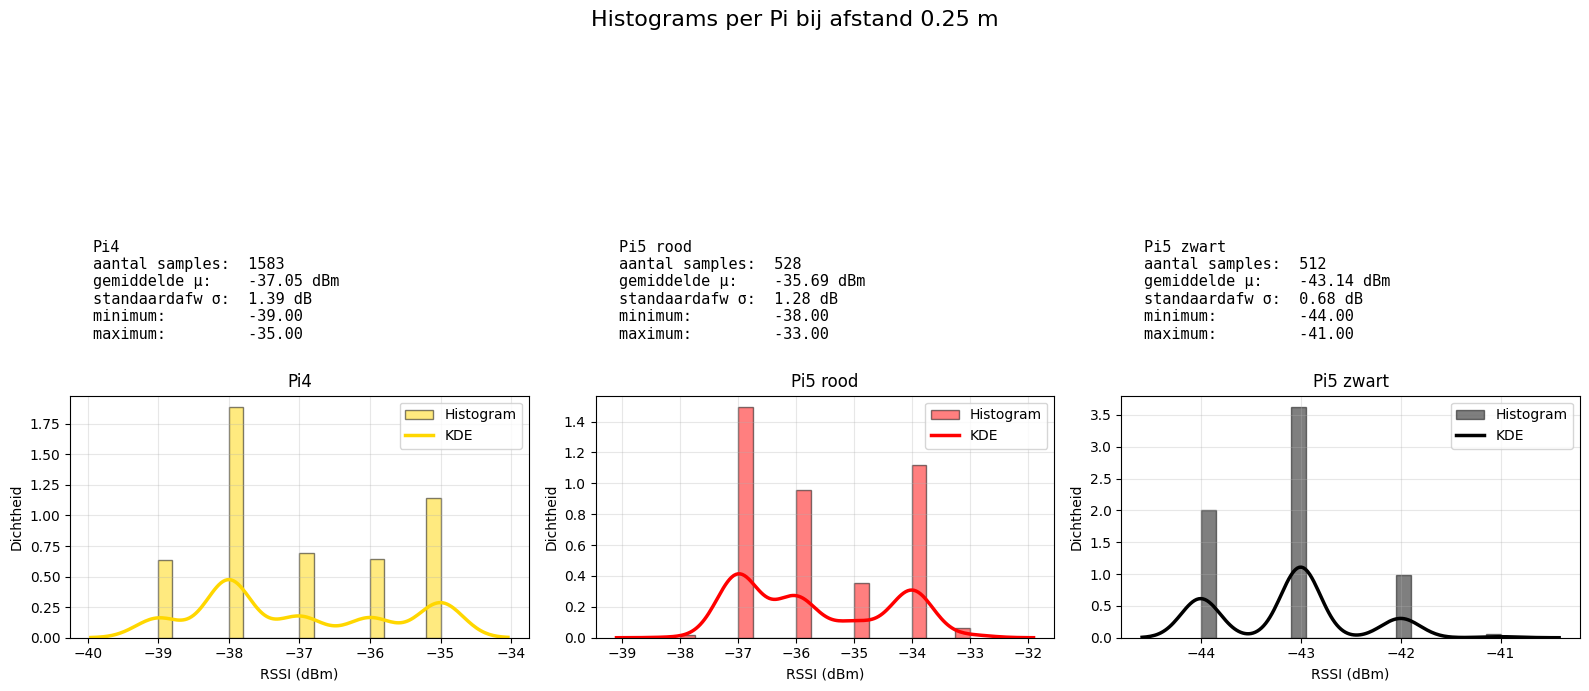


   AFSTAND = 0.5 meter


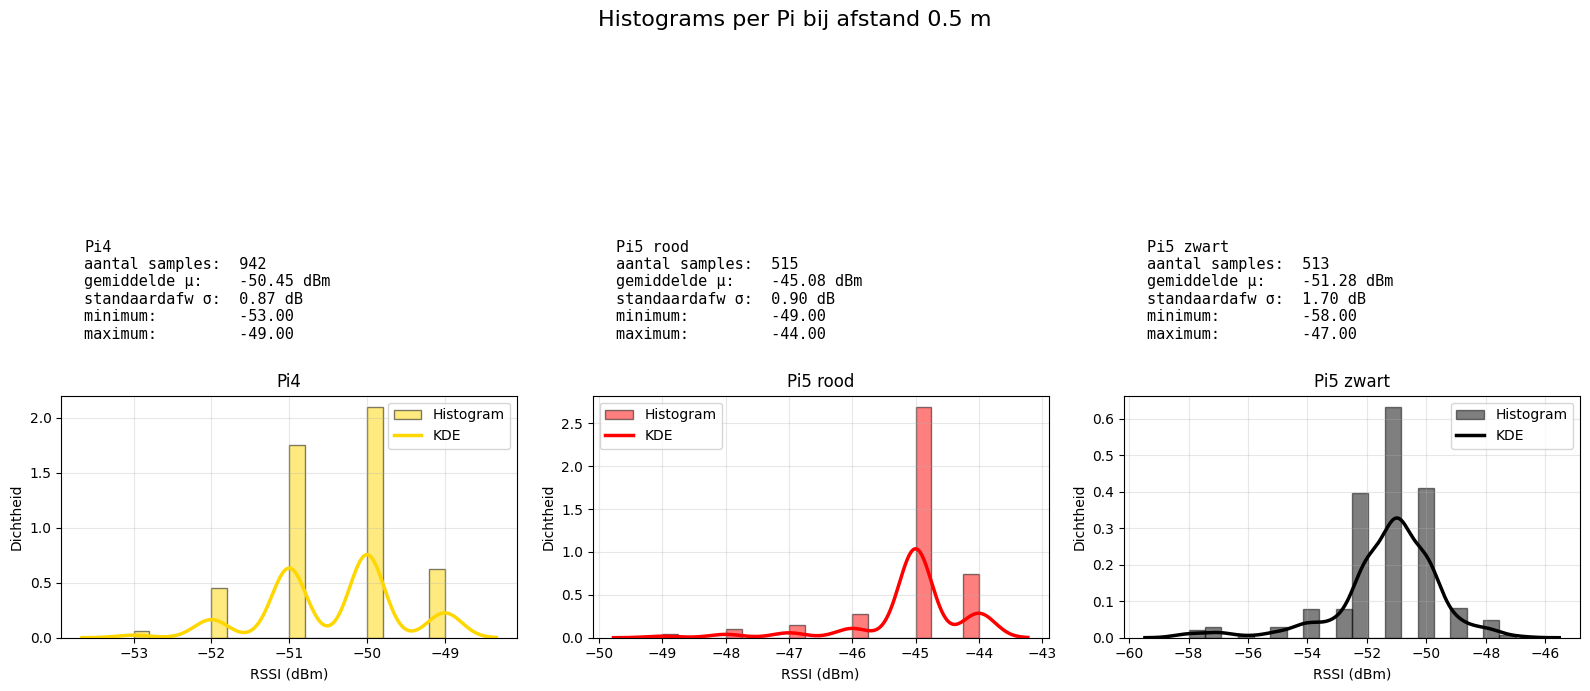


   AFSTAND = 0.75 meter


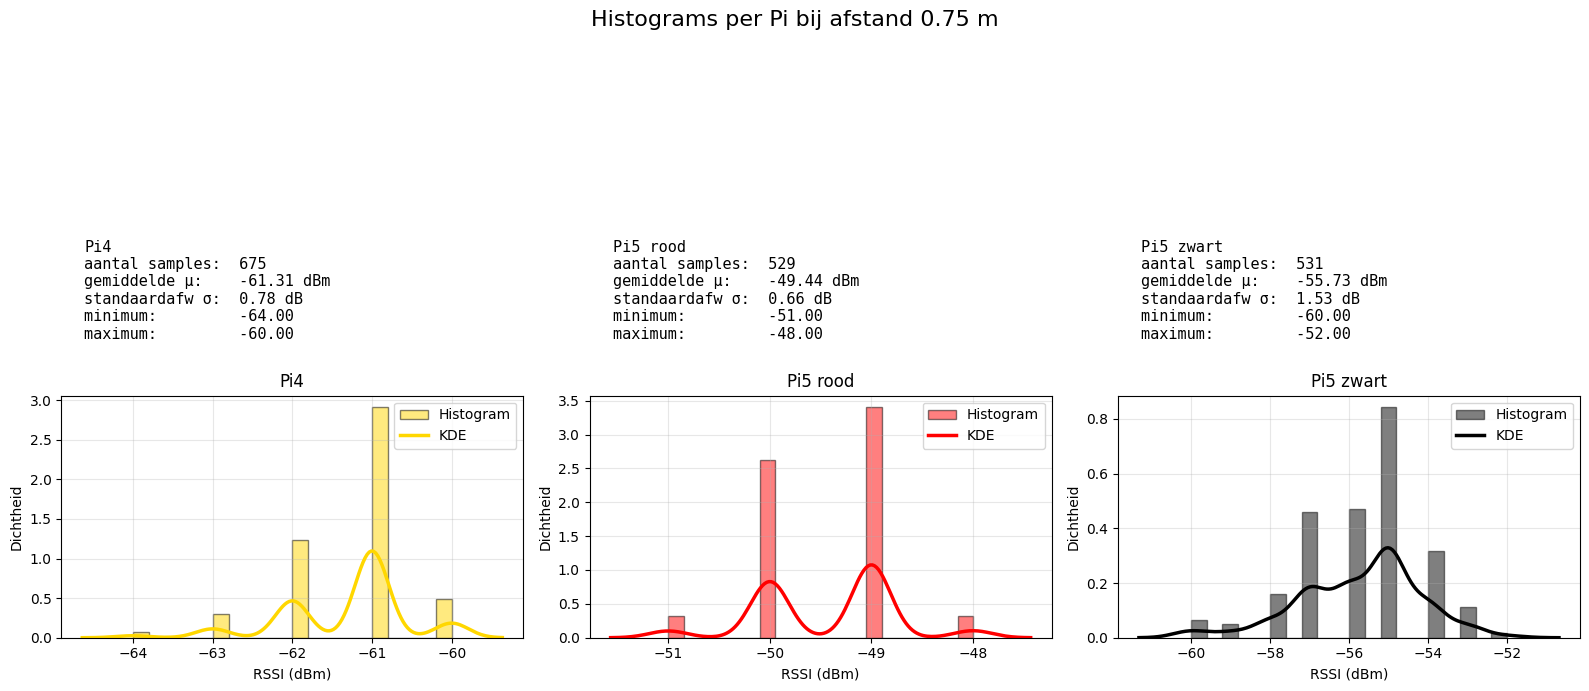


   AFSTAND = 1.0 meter


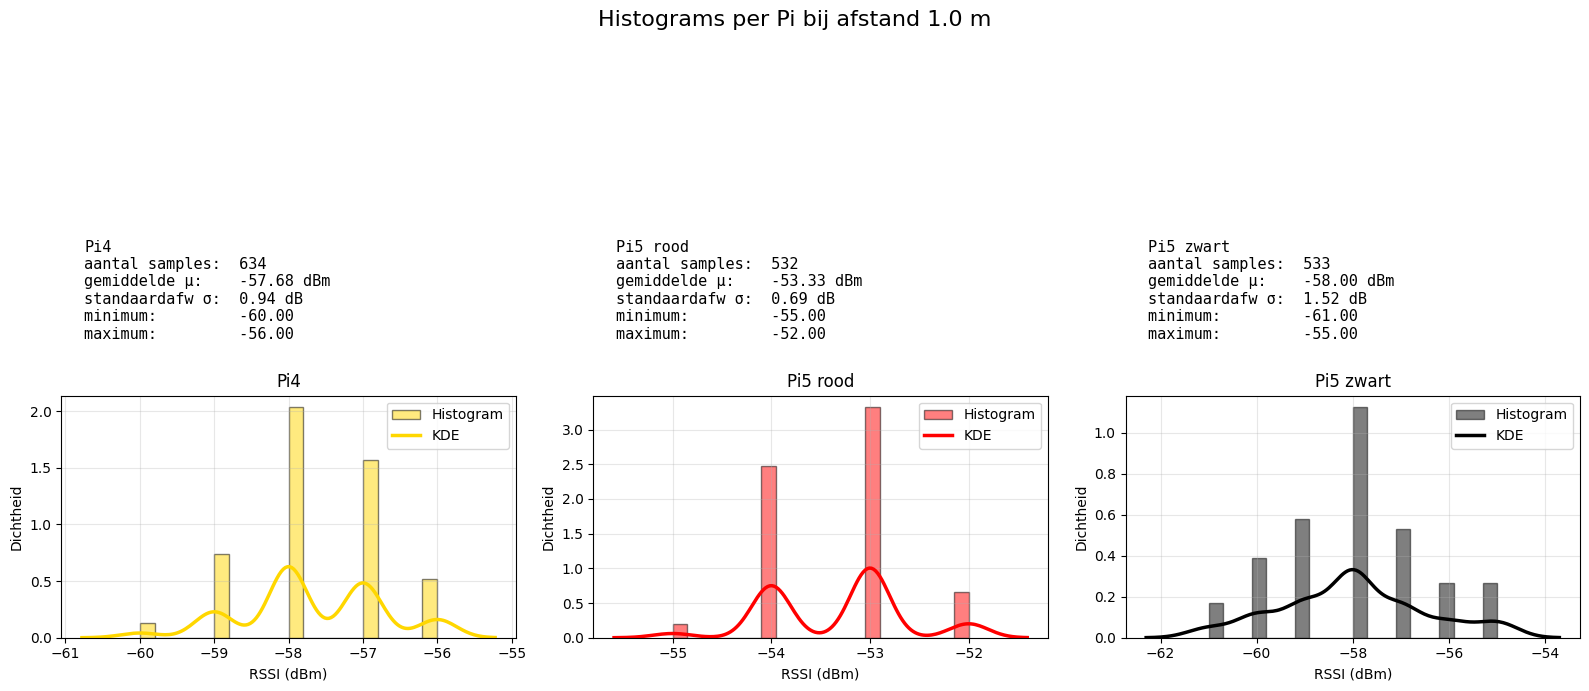


   AFSTAND = 1.5 meter


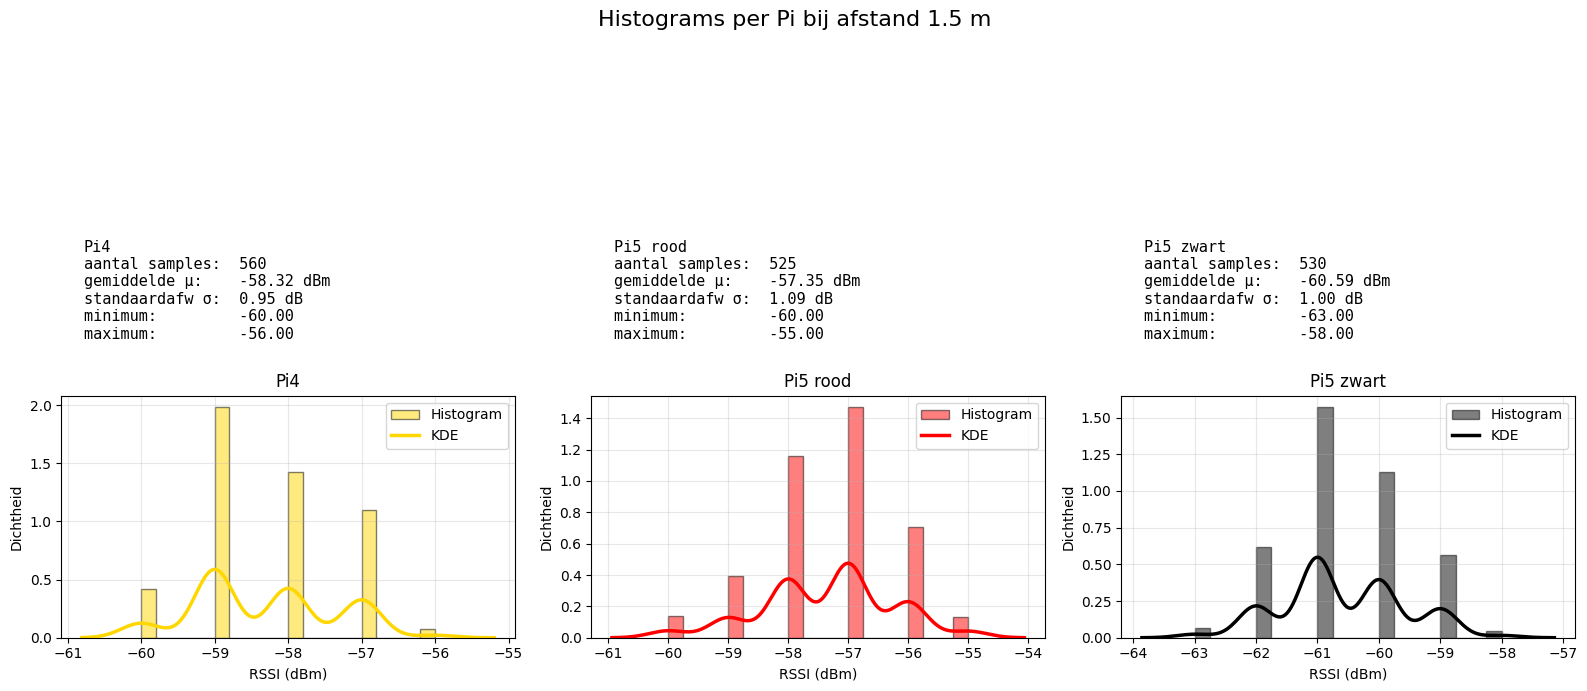


   AFSTAND = 2.0 meter


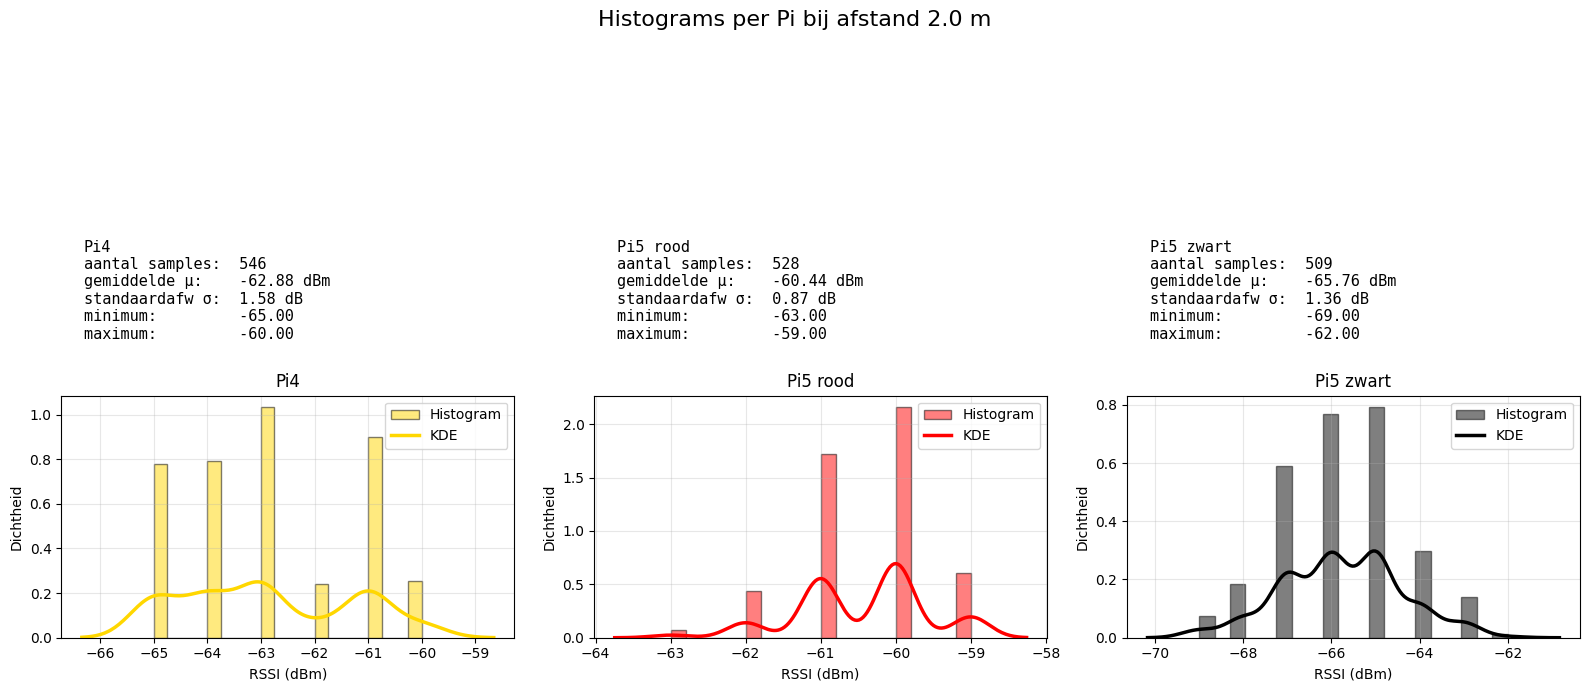


   AFSTAND = 2.5 meter


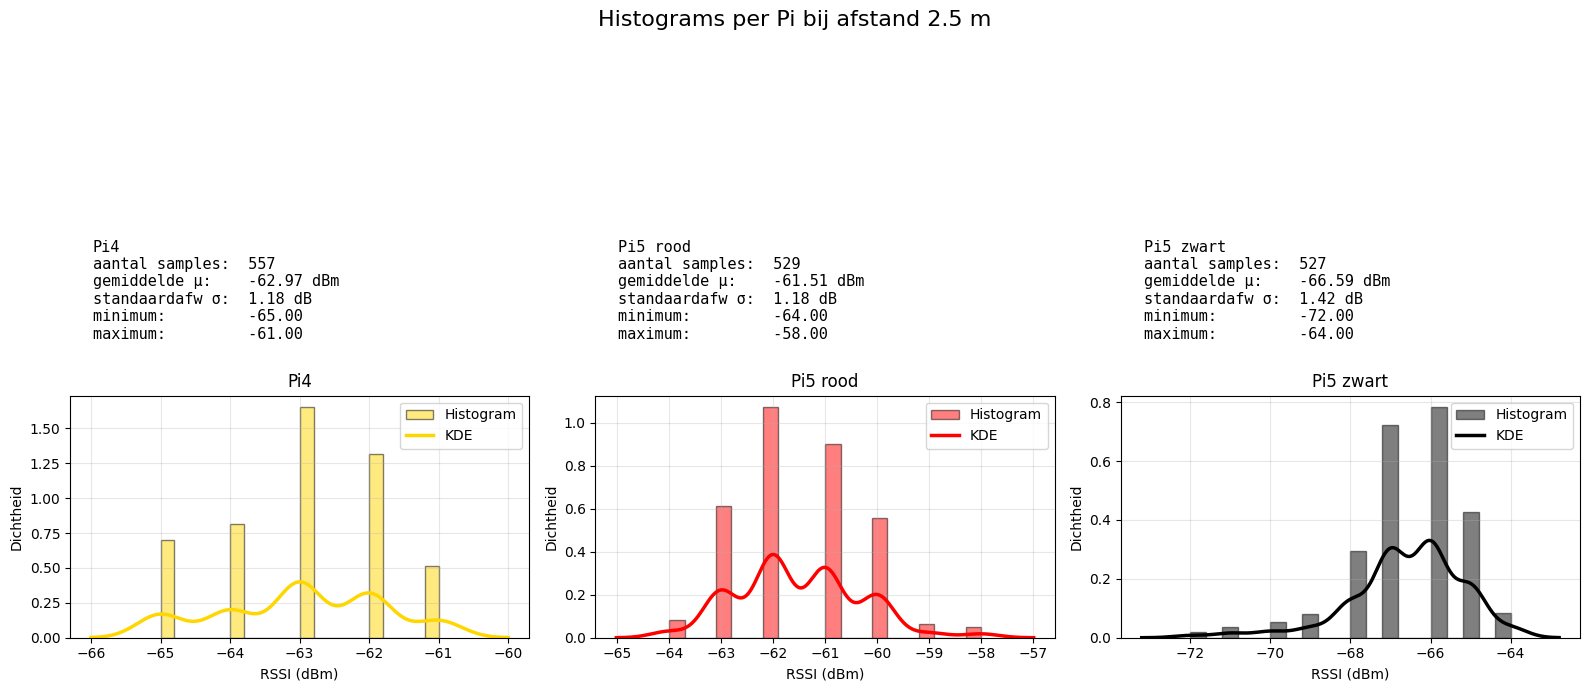


   AFSTAND = 3.0 meter


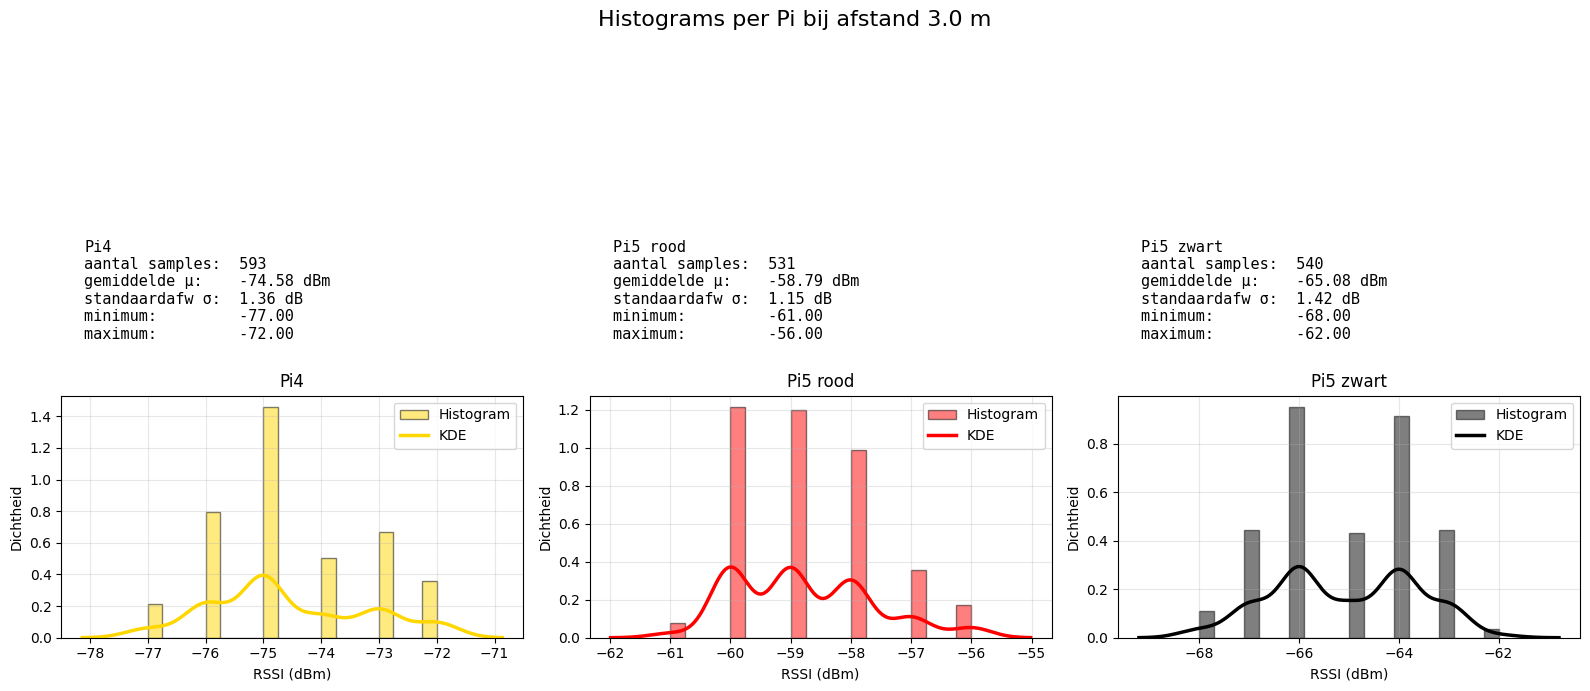


   AFSTAND = 3.5 meter


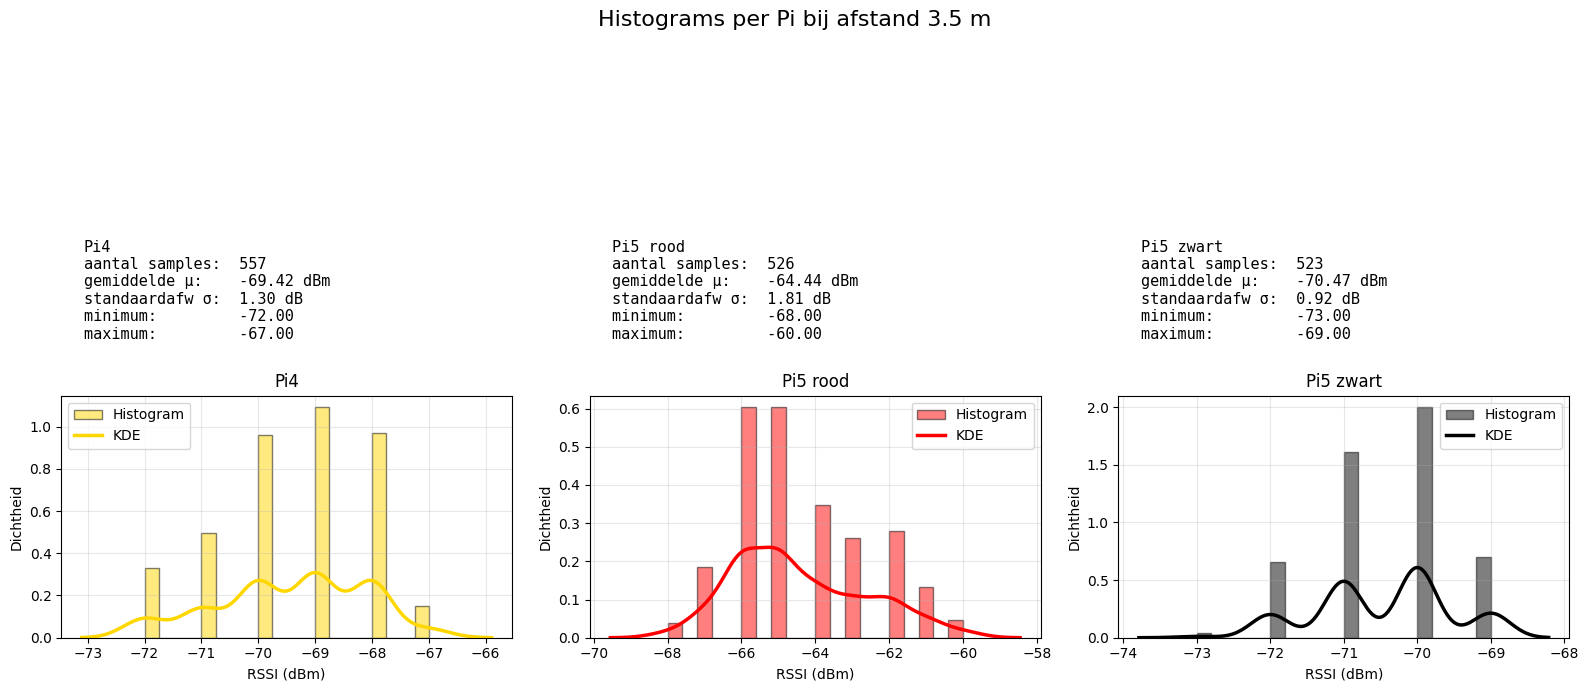


   AFSTAND = 4.0 meter


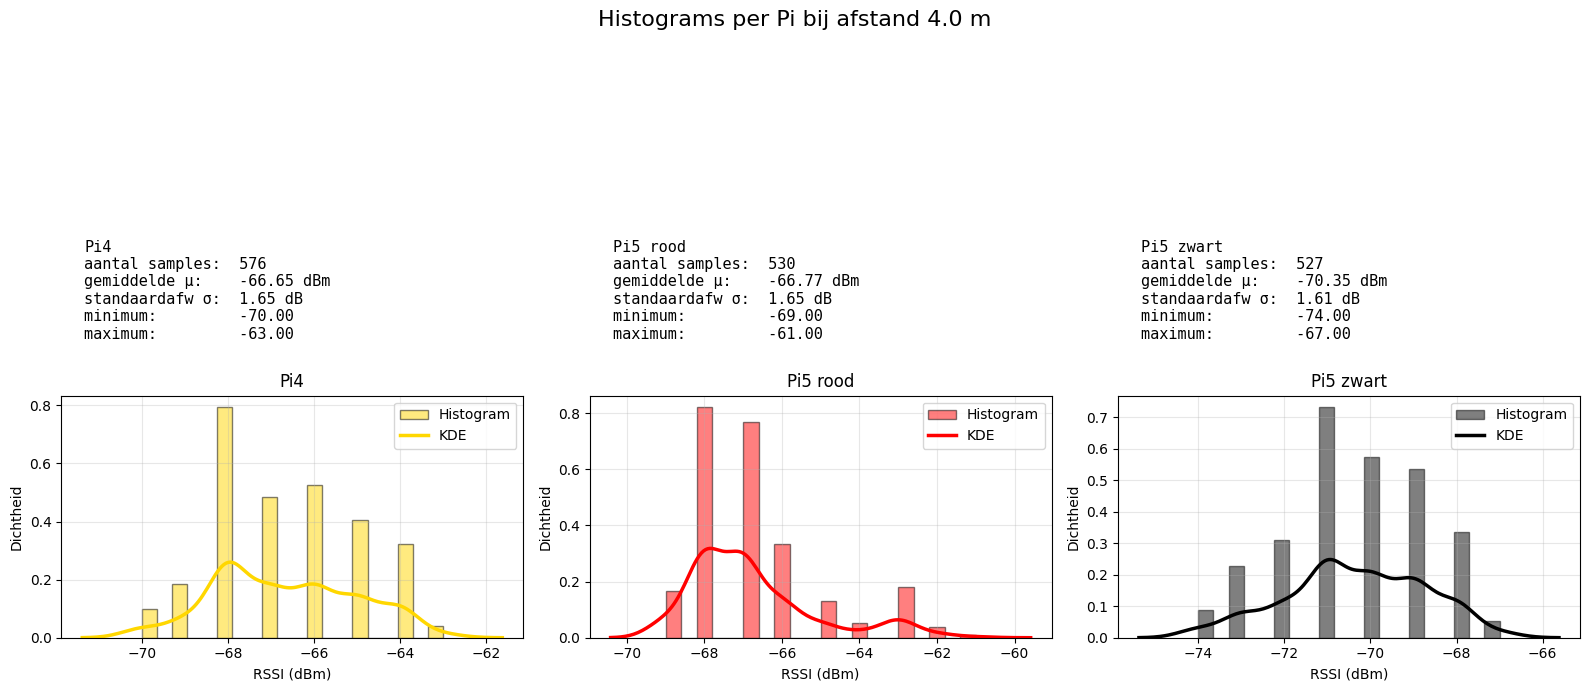


   AFSTAND = 4.5 meter


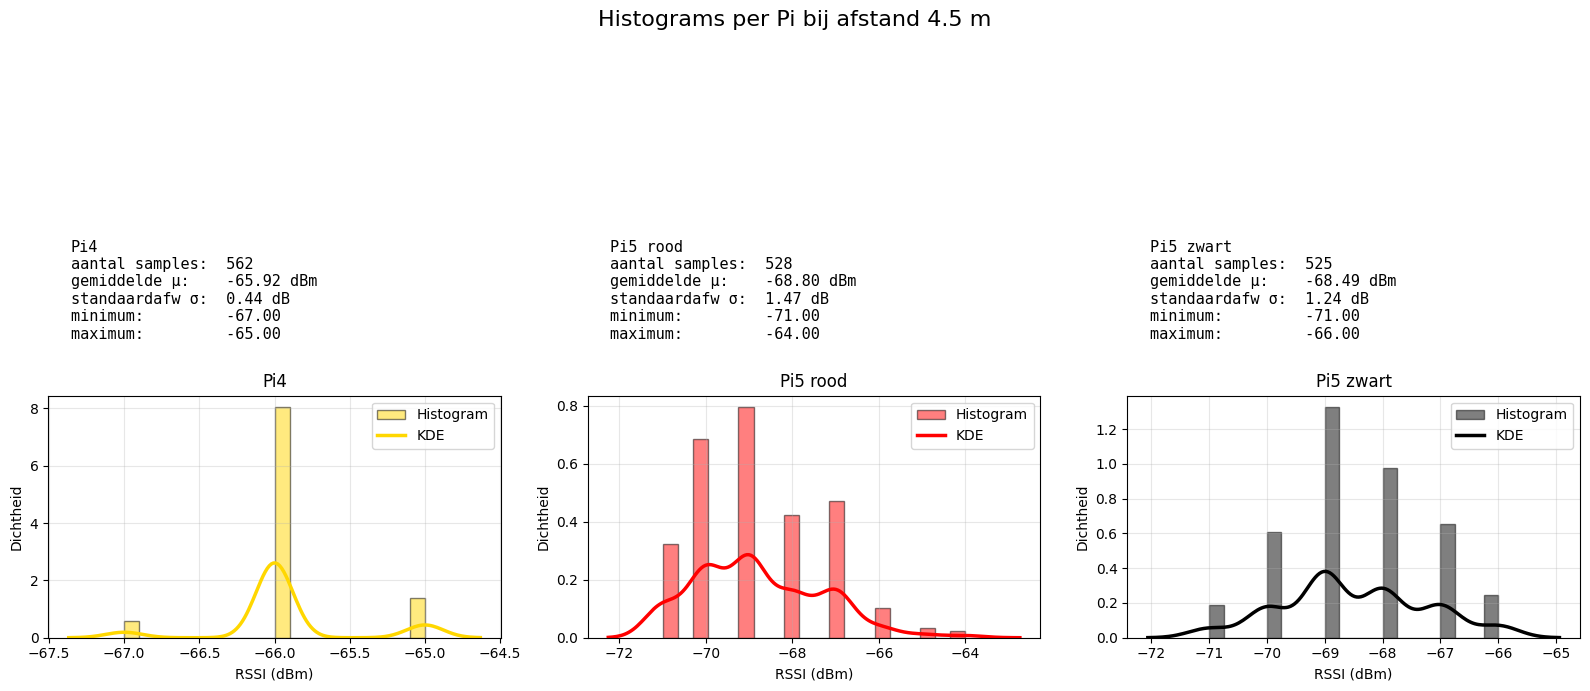


   AFSTAND = 5.0 meter


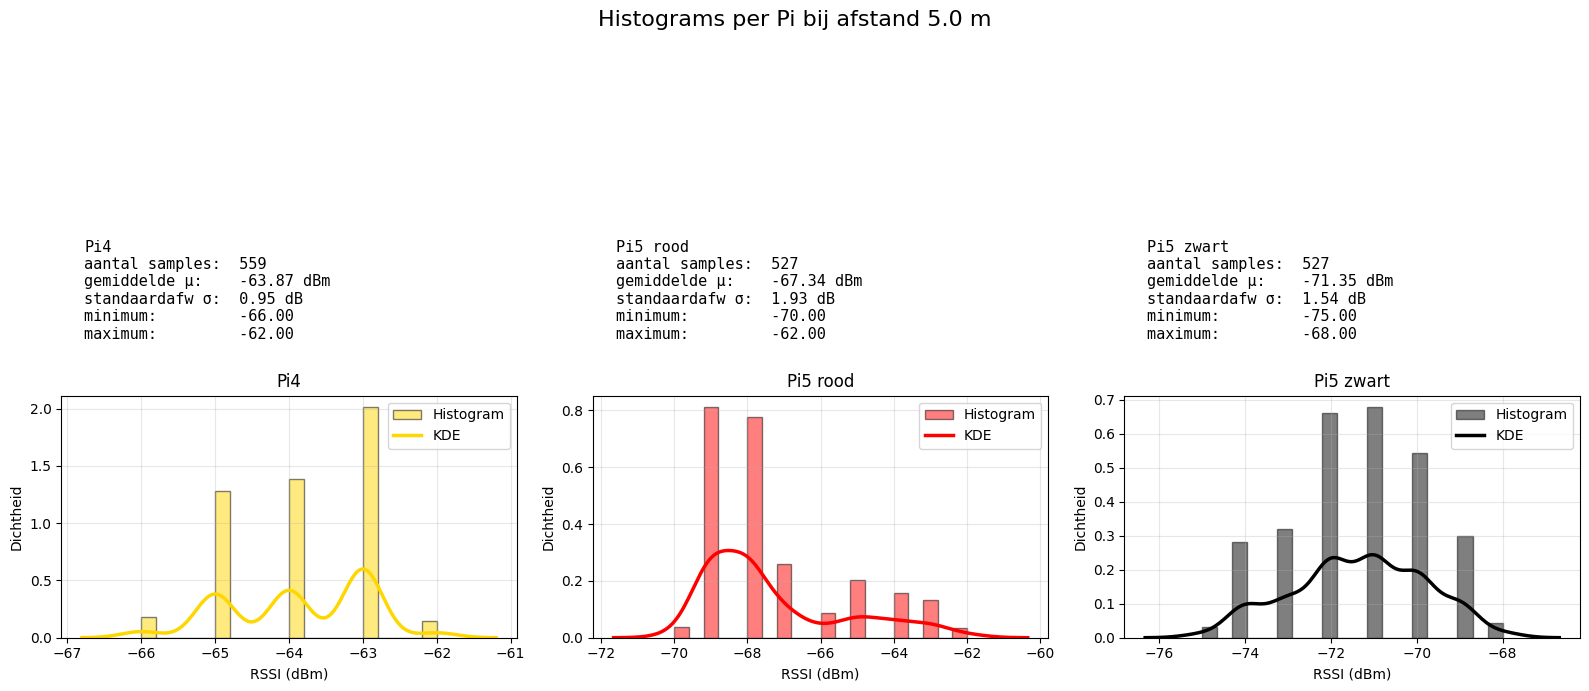


   AFSTAND = 6.0 meter


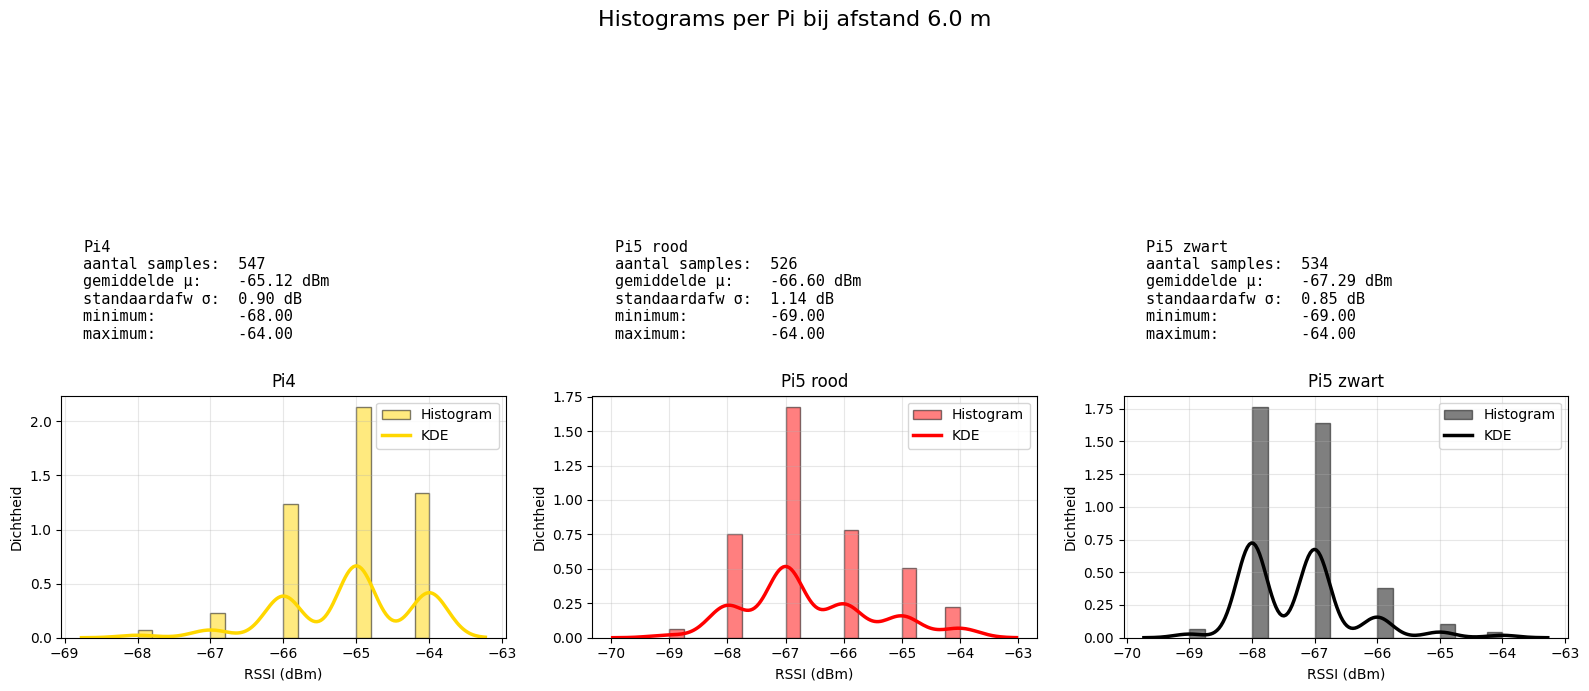


   AFSTAND = 7.0 meter


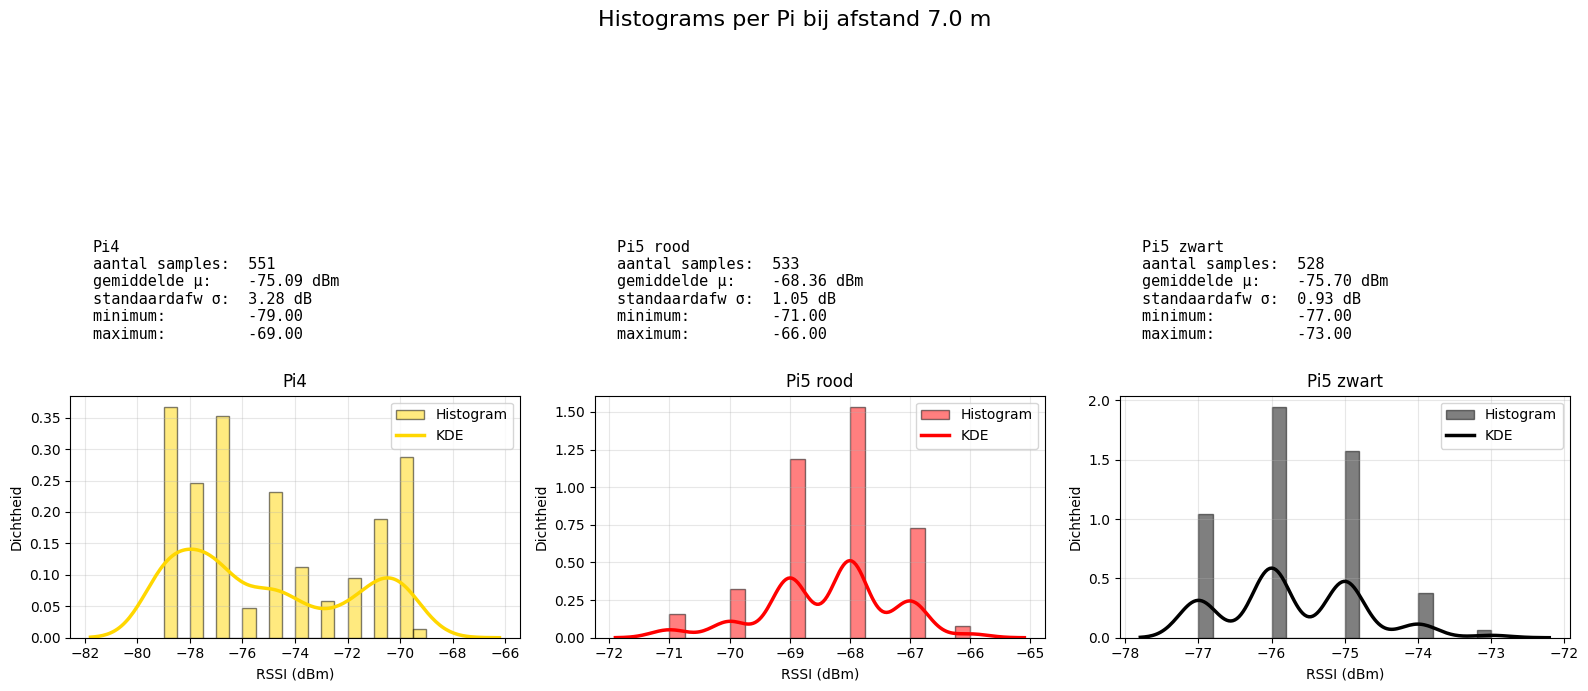


   AFSTAND = 8.0 meter


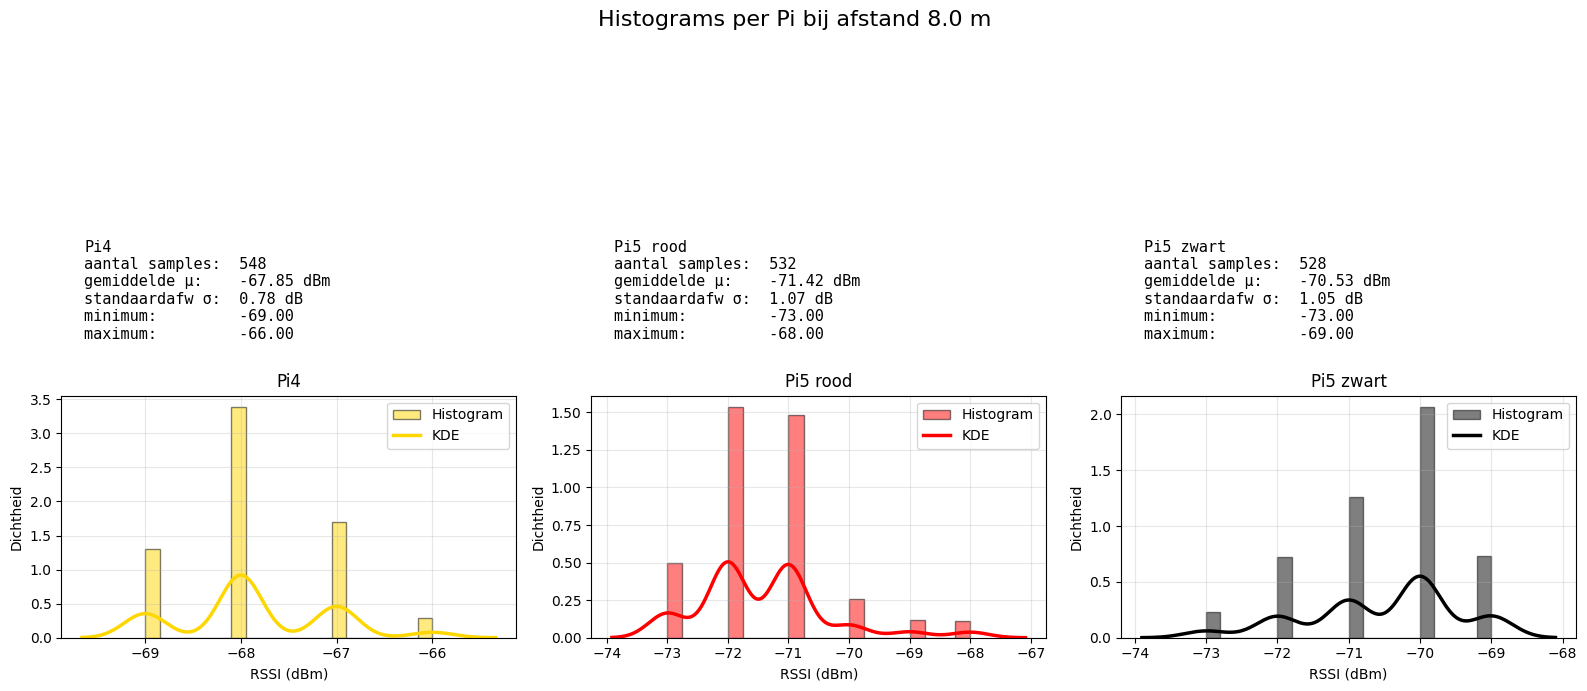


   AFSTAND = 9.0 meter


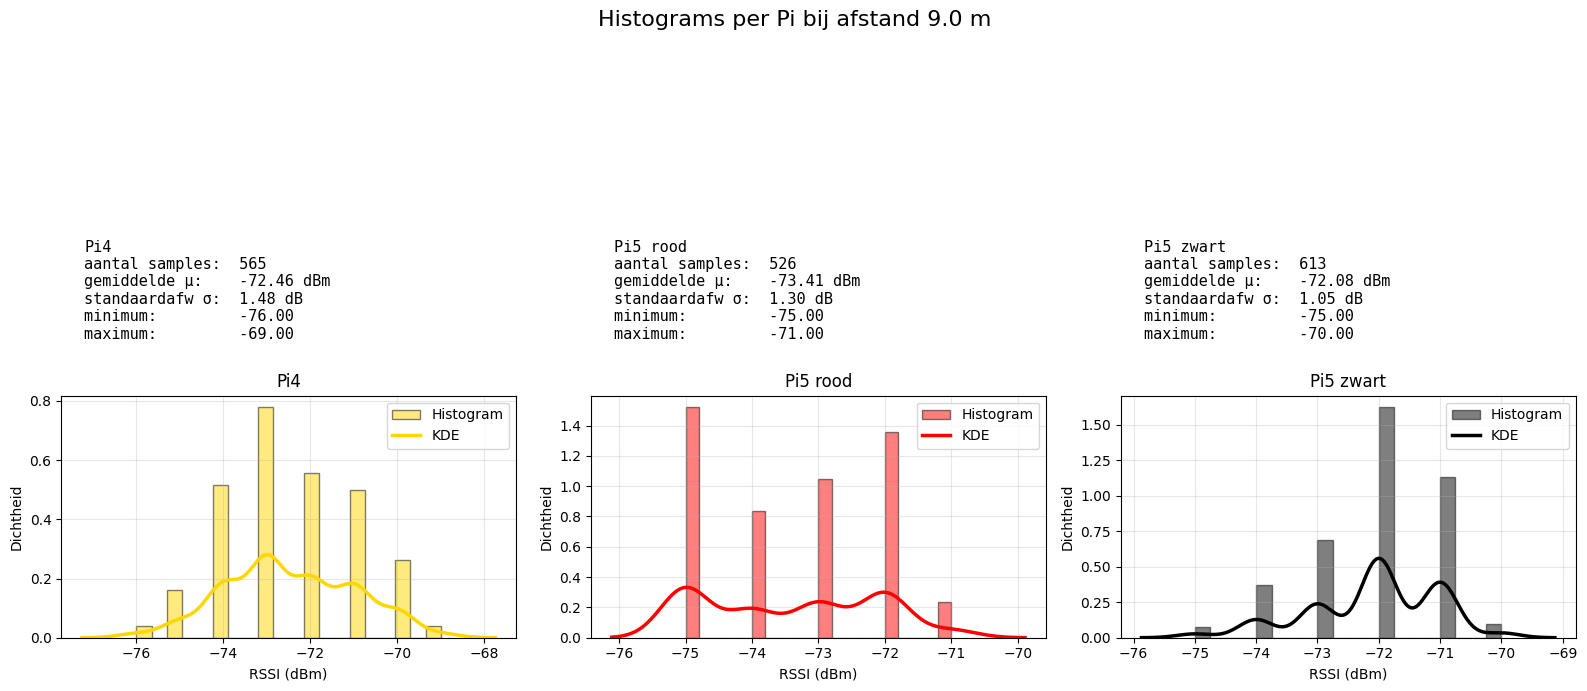


   AFSTAND = 10.0 meter


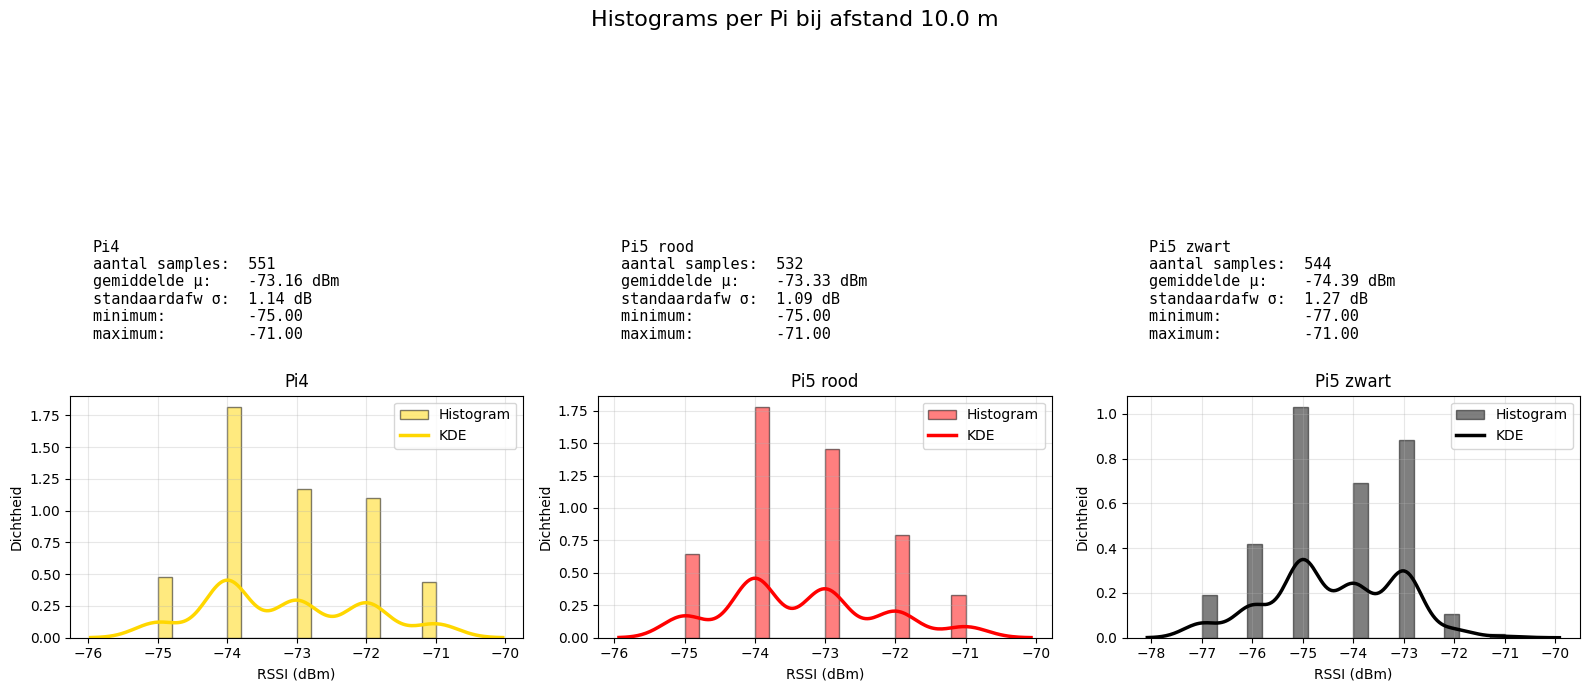

In [13]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Kleuren per Pi
colors = {
    "Pi4": "gold",
    "Pi5 rood": "red",
    "Pi5 zwart": "black"
}

# ---------- HISTOGRAMMEN PER PI (tekst + histogram onder elkaar) ----------
for dist in alle_afstanden:
    print(f"\n==========================")
    print(f"   AFSTAND = {dist} meter")
    print(f"==========================")

    # 3 kolommen, 2 rijen → 1ste rij = tekst, 2e rij = histogram
    fig, axes = plt.subplots(2, 3, figsize=(16, 7))
    fig.suptitle(f"Histograms per Pi bij afstand {dist} m", fontsize=16)

    for i, (naam, df) in enumerate(data.items()):
        
        values = df[df["dist_m"] == dist]["rssi_dbm"].values
        count = len(values)

        # TEKST bovenaan (rij 0)
        ax_text = axes[0, i]
        ax_text.axis("off")  # geen grafiek, alleen tekst
        
        if count == 0:
            ax_text.text(0.1, 0.5, f"{naam}\nGeen data", fontsize=12)
            # Lege histogram
            ax_hist = axes[1, i]
            ax_hist.set_title(naam)
            continue

        mu = np.mean(values)
        sigma = np.std(values, ddof=1)
        min_v = np.min(values)
        max_v = np.max(values)

        tekst = (
            f"{naam}\n"
            f"aantal samples:  {count}\n"
            f"gemiddelde μ:    {mu:.2f} dBm\n"
            f"standaardafw σ:  {sigma:.2f} dB\n"
            f"minimum:         {min_v:.2f}\n"
            f"maximum:         {max_v:.2f}\n"
        )
        ax_text.text(0.05, 0.2, tekst, fontsize=11, family="monospace", va="top")

        # HISTOGRAM + KDE eronder (rij 1)
        ax_hist = axes[1, i]
        
        # Histogram
        ax_hist.hist(values, bins=20, color=colors[naam], alpha=0.5, 
                     density=True, label="Histogram", edgecolor='black')
        
        # KDE met seaborn
        sns.kdeplot(values, ax=ax_hist, color=colors[naam], 
                    linewidth=2.5, label="KDE")
        
        ax_hist.set_title(naam)
        ax_hist.set_xlabel("RSSI (dBm)")
        ax_hist.set_ylabel("Dichtheid")
        ax_hist.legend()
        ax_hist.grid(alpha=0.3)

    plt.tight_layout()
    plt.show()

Boxplots

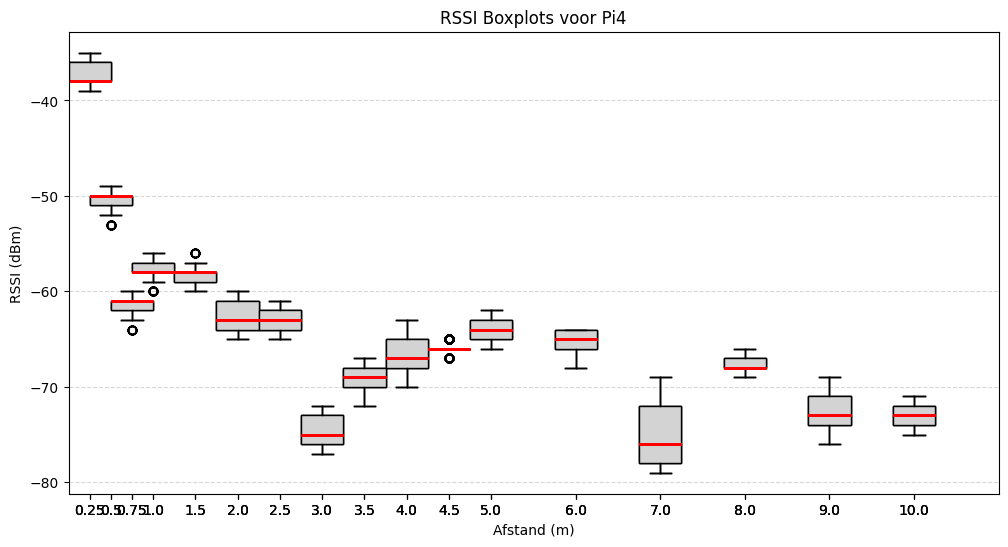

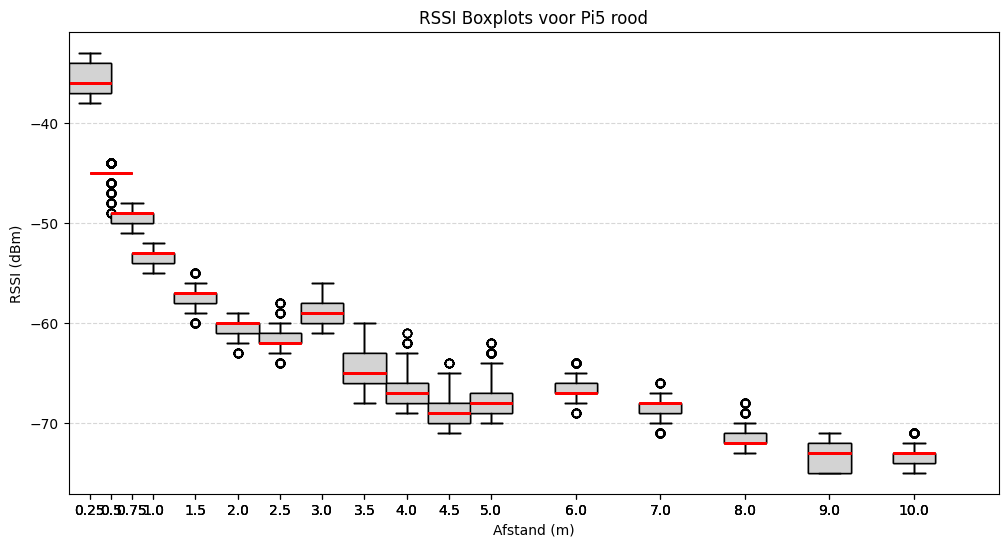

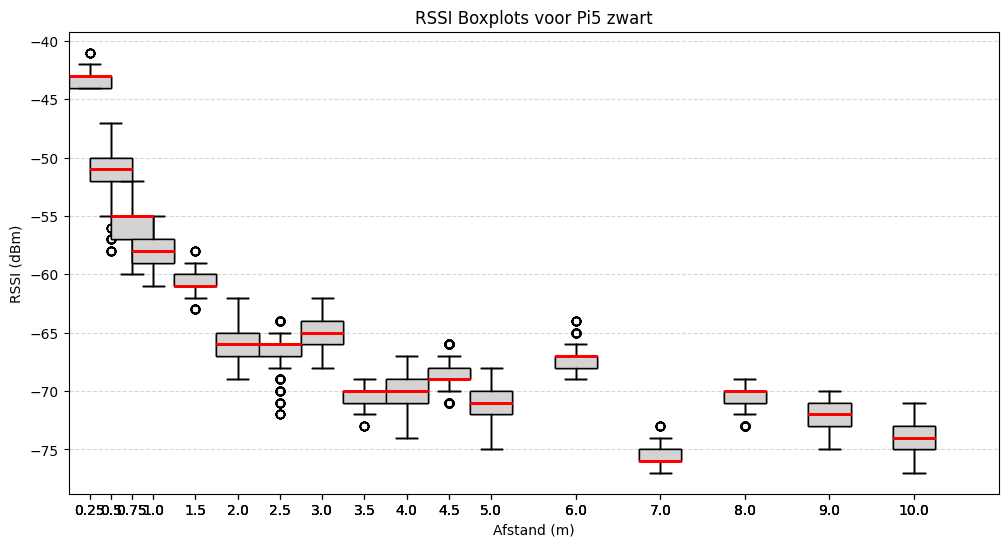

In [14]:
# ---------- BOXPLOTS PER PI (x-as altijd 0 → 10 m) ----------
for naam, df in data.items():

    fig = plt.figure(figsize=(12, 6))
    plt.title(f"RSSI Boxplots voor {naam}")

    box_data = []
    positions = []
    labels = []

    for dist in alle_afstanden:
        values = df[df['dist_m'] == dist]['rssi_dbm'].values
        if len(values) > 0:
            box_data.append(values)
            positions.append(dist)
            labels.append(str(dist))

    plt.boxplot(
        box_data,
        positions=positions,        # afstand op x-as
        patch_artist=True,
        boxprops=dict(facecolor='lightgray', color='black'),
        medianprops=dict(color='red', linewidth=2),
        whiskerprops=dict(color='black'),
        capprops=dict(color='black')
    )

    plt.xlabel("Afstand (m)")
    plt.ylabel("RSSI (dBm)")
    plt.grid(axis='y', linestyle='--', alpha=0.5)

    # 🔥 Belangrijk: vaste x-as van 0 → 10 m
    plt.xlim(0, 11)

    plt.show()


Sigma standaardafwijking uitgezet per afstand gewoon om het verband eens te zien per pi 

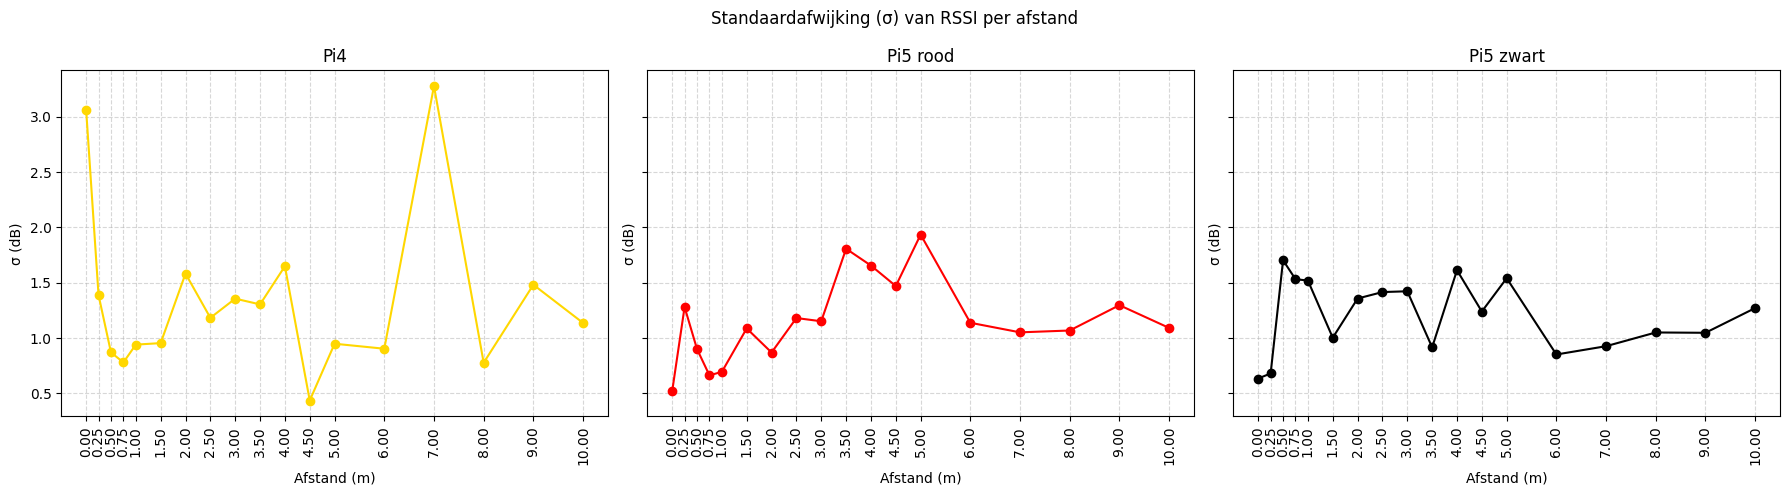

In [15]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Kleuren per Pi
colors = {
    "Pi4": "gold",
    "Pi5 rood": "red",
    "Pi5 zwart": "black"
}

# σ per afstand berekenen voor elke Pi
sigma_data = {}

for naam, df in data.items():

    dists = sorted(df["dist_m"].unique())
    sigmas = []

    for dist in dists:
        values = df[df["dist_m"] == dist]["rssi_dbm"].values
        
        if len(values) > 1:
            sigma = np.std(values, ddof=1)
        else:
            sigma = np.nan

        sigmas.append(sigma)

    sigma_data[naam] = (dists, sigmas)

# Plot
fig, axes = plt.subplots(1, 3, figsize=(18, 5), sharey=True)
fig.suptitle("Standaardafwijking (σ) van RSSI per afstand")

for ax, (naam, (dists, sigmas)) in zip(axes, sigma_data.items()):
    ax.plot(dists, sigmas, marker="o", linestyle="-", color=colors[naam])
    ax.set_title(naam)
    ax.set_xlabel("Afstand (m)")
    ax.set_ylabel("σ (dB)")
    ax.grid(True, linestyle="--", alpha=0.5)
    ax.set_xticks(dists)

    # <<< ROTATE LABELS >>>
    ax.tick_params(axis='x', rotation=90)

plt.tight_layout()
plt.show()


Sigmas verwerken in json bestand dus sigma berekenen per afstand per pi

In [16]:
import json
import numpy as np

# σ per Pi per afstand opslaan
sigma_json = {}

for naam, df in data.items():

    pi_key = naam.replace(" ", "_").lower()   # pi4 → "pi4", Pi5 rood → "pi5_rood"

    sigma_json[pi_key] = {}

    # Unieke afstanden sorteren
    dists = sorted(df["dist_m"].unique())

    for dist in dists:
        values = df[df["dist_m"] == dist]["rssi_dbm"].values

        if len(values) > 1:
            sigma = float(np.std(values, ddof=1))
        else:
            sigma = None  # te weinig samples → None

        sigma_json[pi_key][str(dist)] = sigma


# --- JSON opslaan ---
with open("sigma_parameters.json", "w") as f:
    json.dump(sigma_json, f, indent=4)

print("✔️ sigma_parameters.json opgeslagen!")


✔️ sigma_parameters.json opgeslagen!
